In [ ]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import scipy.io as sio
import cmaps
from matplotlib.colors import LinearSegmentedColormap

In [10]:
nudg_ds = xr.open_dataset('./ECS_nudgcoef.nc')
nudg1_ds = xr.open_dataset('./ecsldhy_nudgcoef_v2.nc')




In [31]:
nudg_ds

<xarray.Dataset>
Dimensions:           (eta_rho: 362, xi_rho: 242, s_rho: 20)
Dimensions without coordinates: eta_rho, xi_rho, s_rho
Data variables:
    spherical         int32 1
    lon_rho           (eta_rho, xi_rho) float64 117.7 117.8 ... 129.6 129.7
    lat_rho           (eta_rho, xi_rho) float64 25.02 25.0 24.98 ... 39.45 39.44
    M3_NudgeCoef      (s_rho, eta_rho, xi_rho) float64 3.0 3.0 3.0 ... 2.186 3.0
    temp_NudgeCoef    (s_rho, eta_rho, xi_rho) float64 3.0 3.0 3.0 ... 2.186 3.0
    salt_NudgeCoef    (s_rho, eta_rho, xi_rho) float64 ...
    tracer_NudgeCoef  (s_rho, eta_rho, xi_rho) float64 ...
Attributes:
    type:      Nudging Coeffcients file
    title:     North Atlantic Damee #4, 0.75 Resolution
    grd_file:  ECSLDHY_grd_v11.nc
    history:   Nudging coefficient file created from d_nudgcoef.m: Wednesday ...

In [22]:
diff_nudg = nudg1_ds.M3_NudgeCoef.data - nudg_ds.M3_NudgeCoef.data
diff_nudg.shape

(20, 362, 242)

/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_42489/2490860484.py:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(nudg1_ds.lon_rho.data,nudg1_ds.lat_rho.data,diff_nudg[19,:,:])


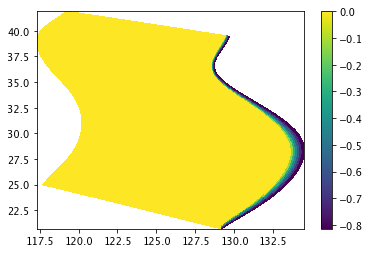

In [34]:
plt.pcolor(nudg1_ds.lon_rho.data,nudg1_ds.lat_rho.data,diff_nudg[19,:,:])
plt.colorbar()

In [15]:
# from importlib import reload
# reload(rw)
import roms_workspace as rw
import scipy as sci
import os
##========================================================================##
#  Stick to the guideline of beginning with the simplest approach,
#  only sea surface temperature (SST) was assimilated, and only
#  initial condition was adjusted.
#  Here we first validated the performance of ROMS I4D-VAR configured
#  in this strategy.
##========================================================================##
my_rootnl = '/Volumes/Elements SE/roms4dvar_ecs'
my_rootda = '/Volumes/Elements SE/roms4dvar_ecs/i4dvar_outputs'
nl_workspace_info = {
                     # 'run04/outputs':'FORWARD',
                     'run17_1hr/outputs':'FORWARD',
                     'run17_drggrd/outputs':'FORWARD drggrd',
                    'run17_drggrdnocorr/outputs':'FORWARD drggrd no_correction',
                     
                     }
da_workspace_info = {
                     # 'workspace':'Adj ALL',
                     
                     'workspace02':'Adj INI',
                     'workspace03_nud_3d_b12hr':'Adj INI 12hr begin',
                     'workspace03_nud_2d':'NUD+Adj INI',
                     'workspace03_nud_3d':'NUD+Adj INI+3DAY',
            
                     }

var = 'u'
areas = {
        #  'bh': ('Bohai Sea', [0,7]),
        # 'ys': ('Yellow Sea', [6.5,11]),
        # 'cre': ('Changjiang River Estuary',[10.5,14.5]),
        # 'ks': ('Kuroshio Current System', [21.5,24]),
        'all': ('East China Sea', [10,25])
}


nl_Workspaces = []
for i in range(len(nl_workspace_info)):
    nl_Workspaces.append(rw.Nl_workspace( MY_ROOT         =my_rootnl,
                                    workspace_name  =list(nl_workspace_info.keys())[i],
                                    workspace_detail=list(nl_workspace_info.values())[i]
                                   ))
    nl_Workspaces[i].load_mtfroms(isAna=False,Surf=True)

nl_Workspaces.append(rw.Da_workspace( MY_ROOT         =my_rootnl,
                                    workspace_name  ='run17_v4_v2_nudfile/outputs',
                                    workspace_detail='FORWARD nudging from rong'
                                   ))
nl_Workspaces[3].load_mtfroms(isAna=False,Surf=True)



dab_Workspaces = []
for i in range(len(da_workspace_info)):
    dab_Workspaces.append(rw.Da_workspace(MY_ROOT         =my_rootda, 
                                    workspace_name  = list(da_workspace_info.keys())[i],
                                    workspace_detail= list(da_workspace_info.values())[i]
                                   ))
    dab_Workspaces[i].load_mtfroms(isAna=False, Surf=True)

daa_Workspaces = []
for i in range(len(da_workspace_info)):
    daa_Workspaces.append(rw.Da_workspace(MY_ROOT         =my_rootda, 
                                    workspace_name  = list(da_workspace_info.keys())[i],
                                    workspace_detail= list(da_workspace_info.values())[i]
                                   ))
    daa_Workspaces[i].load_mtfroms(isAna=True, Surf=True)

obs_ds = xr.open_dataset(os.path.join(my_rootda,
                                      list(da_workspace_info.keys())[0],
                                      'OBS',
                                      'ecs_oisst_super_201701_full.nc'
                                      ))
obs_time = obs_ds.obs_time.data.astype('float')/86400/1e9
obs_value = obs_ds.obs_value.data
obs_lon = obs_ds.obs_lon.data
obs_lat = obs_ds.obs_lat.data
obs_UVars = {} 
area_index={}
obs_inarea ={}
# area iteration 
nl_UVars = {}
for iw in range(len((nl_workspace_info))):
    for area in list(areas.keys()):
        print('loading %s in %s  area...'%(var,area))
        if iw == 0:
            nl_UVars[area] = []
        # loading data from FORWARD model outputs
        nl_UVars[area].append(nl_Workspaces[iw].pull_var2d(varname=         var, area=area,time_range=('2017-01-03','2017-02-02')))

for area in list(areas.keys()):
    print('loading %s in %s  area...'%(var,area))
    # if iw == 0:
    #     nl_UVars[area] = []
    # loading data from FORWARD model outputs
    nl_UVars[area].append(nl_Workspaces[3].pull_var2d(varname=       '%s_sur'%var, area=area,time_range=('2017-01-03','2017-02-02')))

dab_UVars = {}
daa_UVars = {}
for iw in range(len((da_workspace_info))):
    for area in list(areas.keys()):
        print('loading %s in %s  area...'%(var,area))
        if iw == 0:
            
            dab_UVars[area] = []
            daa_UVars[area] = []
        
        
        # loading data from prior outputs

        dab_UVars[area].append(dab_Workspaces[iw].pull_var2d(varname='%s_sur'%var, area=area,time_range=('2017-01-03','2017-02-02')))
        # loading data from posterior outputs
        daa_UVars[area].append(daa_Workspaces[iw].pull_var2d(varname='%s_sur'%var, area=area,time_range=('2017-01-03','2017-02-02')))

        #================================extrapolate observation data to model grid================================
        index_insea = np.where(~np.isnan(daa_UVars[area][0].value[0,:,:]))
        # obs_UVars[area] = np.zeros(
        #                         [len(obs_ds.survey_time.data), 
        #                          len(index_insea[0])]
        #                         ) 
        # for itime, itime_obs in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9):
        #     index_thistime = np.where(obs_time == itime_obs)[0]
        #     obs_UVars[area][itime,:] = sci.interpolate.griddata(
        #                                                        np.c_[obs_lon[index_thistime],
        #                                                             obs_lat[index_thistime]],
        #                                                        obs_value[index_thistime],
        #                                                        np.c_[daa_UVars[area][0].lon[index_insea],
        #                                                              daa_UVars[area][0].lat[index_insea]],
        #                                                        method ='nearest')
        #==========================================================================================================
        # note that it's more resonable to interp model data to observation location 
        # since model grider is finer than observaion resolution
        #==========================================================================================================


Workspace: /Volumes/Elements SE/roms4dvar_ecs/run17_1hr/outputs
Workspace: /Volumes/Elements SE/roms4dvar_ecs/run17_drggrd/outputs
Workspace: /Volumes/Elements SE/roms4dvar_ecs/run17_drggrdnocorr/outputs
Workspace: /Volumes/Elements SE/roms4dvar_ecs/run17_v4_v2_nudfile/outputs
Workspace: /Volumes/Elements SE/roms4dvar_ecs/i4dvar_outputs/workspace02
Workspace: /Volumes/Elements SE/roms4dvar_ecs/i4dvar_outputs/workspace03_nud_3d_b12hr
Workspace: /Volumes/Elements SE/roms4dvar_ecs/i4dvar_outputs/workspace03_nud_2d
Workspace: /Volumes/Elements SE/roms4dvar_ecs/i4dvar_outputs/workspace03_nud_3d
Workspace: /Volumes/Elements SE/roms4dvar_ecs/i4dvar_outputs/workspace02
Workspace: /Volumes/Elements SE/roms4dvar_ecs/i4dvar_outputs/workspace03_nud_3d_b12hr
Workspace: /Volumes/Elements SE/roms4dvar_ecs/i4dvar_outputs/workspace03_nud_2d
Workspace: /Volumes/Elements SE/roms4dvar_ecs/i4dvar_outputs/workspace03_nud_3d
loading u in all  area...
loading u in all  area...
loading u in all  area...
loadin

In [23]:
nl_UVars['all'][2].ocean_time

<xarray.DataArray 'ocean_time' (ocean_time: 744)>
array(['2017-01-03T00:30:00.000000000', '2017-01-03T01:30:00.000000000',
       '2017-01-03T02:30:00.000000000', ..., '2017-02-02T21:30:00.000000000',
       '2017-02-02T22:30:00.000000000', '2017-02-02T23:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    s_rho       float64 -0.025
  * ocean_time  (ocean_time) datetime64[ns] 2017-01-03T00:30:00 ... 2017-02-0...
Attributes:
    long_name:  averaged time since initialization
    field:      time, scalar, series

In [16]:


var = 'v'


obs_VVars = {} 
area_index=daa_VVars_inarea ={}
# area iteration 
nl_VVars = {}
for iw in range(len((nl_workspace_info))):
    for area in list(areas.keys()):
        print('loading %s in %s  area...'%(var,area))
        if iw == 0:
            nl_VVars[area] = []
        # loading data from FORWARD model outputs
        nl_VVars[area].append(nl_Workspaces[iw].pull_var2d(varname=         var, area=area,time_range=('2017-01-03','2017-02-02')))
        
for area in list(areas.keys()):
    print('loading %s in %s  area...'%(var,area))
    # if iw == 0:
    #     nl_VVars[area] = []
    # loading data from FORWARD model outputs
    nl_VVars[area].append(nl_Workspaces[3].pull_var2d(varname=       '%s_sur'%var, area=area,time_range=('2017-01-03','2017-02-02')))

dab_VVars = {}
daa_VVars = {}
for iw in range(len((da_workspace_info))):
    for area in list(areas.keys()):
        print('loading %s in %s  area...'%(var,area))
        if iw == 0:
            
            dab_VVars[area] = []
            daa_VVars[area] = []
        
        
        # loading data from prior outputs

        dab_VVars[area].append(dab_Workspaces[iw].pull_var2d(varname='%s_sur'%var, area=area,time_range=('2017-01-03','2017-02-02')))
        # loading data from posterior outputs
        daa_VVars[area].append(daa_Workspaces[iw].pull_var2d(varname='%s_sur'%var, area=area,time_range=('2017-01-03','2017-02-02')))

        #================================extrapolate observation data to model grid================================
        index_insea = np.where(~np.isnan(daa_VVars[area][0].value[0,:,:]))
        # obs_VVars[area] = np.zeros(
        #                         [len(obs_ds.survey_time.data), 
        #                          len(index_insea[0])]
        # #                         ) 
        # for itime, itime_obs in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9):
        #     index_thistime = np.where(obs_time == itime_obs)[0]
        #     obs_VVars[area][itime,:] = sci.interpolate.griddata(
        #                                                        np.c_[obs_lon[index_thistime],
        #                                                             obs_lat[index_thistime]],
        #                                                        obs_value[index_thistime],
        #                                                        np.c_[daa_VVars[area][0].lon[index_insea],
        #                                                              daa_VVars[area][0].lat[index_insea]],
        #                                                        method ='nearest')
        #==========================================================================================================
        # note that it's more resonable to interp model data to observation location 
        # since model grider is finer than observaion resolution
        #==========================================================================================================


loading v in all  area...
loading v in all  area...
loading v in all  area...
loading v in all  area...
loading v in all  area...
loading v in all  area...
loading v in all  area...
loading v in all  area...


In [17]:
# convert u and v to cartasian coodinate

for iw in range(4):
    for area in list(areas.keys()):
        nl_UVars[area][iw].value_rotate = np.zeros_like(nl_UVars[area][iw].value)
        nl_VVars[area][iw].value_rotate = np.zeros_like(nl_VVars[area][iw].value)
        
        nl_UVars[area][iw].value_rotate = nl_UVars[area][iw].value*np.cos(nl_UVars[area][iw].angle) -\
                                          nl_VVars[area][iw].value*np.sin(nl_UVars[area][iw].angle)
        
        nl_VVars[area][iw].value_rotate = nl_VVars[area][iw].value*np.cos(nl_VVars[area][iw].angle) -\
                                          nl_UVars[area][iw].value*np.sin(nl_VVars[area][iw].angle)


for iw in range(len((da_workspace_info))):
    for area in list(areas.keys()):
        
        
        dab_UVars[area][iw].value_rotate = dab_UVars[area][iw].value*np.cos(dab_UVars[area][iw].angle) -\
                                          dab_VVars[area][iw].value*np.sin(dab_UVars[area][iw].angle)
        
        dab_VVars[area][iw].value_rotate = dab_VVars[area][iw].value*np.cos(dab_VVars[area][iw].angle) +\
                                          dab_UVars[area][iw].value*np.sin(dab_VVars[area][iw].angle)
        
        daa_UVars[area][iw].value_rotate = daa_UVars[area][iw].value*np.cos(daa_UVars[area][iw].angle) -\
                                          daa_VVars[area][iw].value*np.sin(daa_UVars[area][iw].angle)
        
        daa_VVars[area][iw].value_rotate = daa_VVars[area][iw].value*np.cos(daa_VVars[area][iw].angle) +\
                                          daa_UVars[area][iw].value*np.sin(daa_VVars[area][iw].angle)


In [ ]:
#================================calculate area-mean U at observation location================================
# FORWARD model
obs_location = np.c_[
                     obs_lon[np.where(obs_time == 17169.5)[0]],
                     obs_lat[np.where(obs_time == 17169.5)[0]]
                    ]


for iw in range(len((nl_workspace_info))):
    for area in list(areas.keys()):
        nl_UVars[area][iw].val_obsgrd   = np.zeros([len( nl_UVars[area][iw].ocean_time), len(obs_location)])
        for i in range(1):
        
            nl_UVars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[nl_UVars[area][iw].lon.ravel(),
                                                                            nl_UVars[area][iw].lat.ravel()],
                                                                      nl_UVars[area][iw].value_rotate[i,:,:].ravel(),
                                                                      obs_location,
                                                                 )
for iw in range(len((da_workspace_info))):
    for area in list(areas.keys()):



        dab_UVars[area][iw].val_obsgrd  = np.zeros([len(dab_UVars[area][iw].ocean_time), len(obs_location)])

        daa_UVars[area][iw].val_obsgrd  = np.zeros([len(daa_UVars[area][iw].ocean_time), len(obs_location)])



        for i in  range(1):
            dab_UVars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[dab_UVars[area][iw].lon.ravel(),
                                                                            dab_UVars[area][iw].lat.ravel()],
                                                                      dab_UVars[area][iw].value_rotate[i,:,:].ravel(),
                                                                      obs_location,
                                                                      )

        for i in  range(1):
            daa_UVars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[daa_UVars[area][iw].lon.ravel(),
                                                                            daa_UVars[area][iw].lat.ravel()],
                                                                      daa_UVars[area][iw].value_rotate[i,:,:].ravel(),
                                                                      obs_location,
                                                                      )
for area in list(areas.keys()):
    area_index[area] = np.where(~np.isnan(daa_UVars[area][0].val_obsgrd[0,:]))
   
    obs_inarea[area] = np.zeros([30,len(area_index[area][0])])*np.NAN
    # for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9):
    #     obs_thistime = obs_value[np.where(obs_time == itime)[0]]x
    #     obs_inarea[it, :] = obs_thistime[area_index[0]]
    obs_inarea[area] =   [ obs_value[np.where(obs_time == itime)[0]][area_index[area][0]] for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9)]

    
for iw in range(len((nl_workspace_info))):
    for area in list(areas.keys()):
        nl_UVars[area][iw].val_obsgrd   = np.zeros([len( nl_UVars[area][iw].ocean_time), len(obs_location)])
        for i, itime_nl in enumerate(nl_UVars[area][iw].ocean_time):
        
            nl_UVars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[nl_UVars[area][iw].lon.ravel(),
                                                                            nl_UVars[area][iw].lat.ravel()],
                                                                      nl_UVars[area][iw].value_rotate[i,:,:].ravel(),
                                                                      obs_location,
                                                                     method ='nearest')
for iw in range(len((da_workspace_info))):
    for area in list(areas.keys()):



        dab_UVars[area][iw].val_obsgrd  = np.zeros([len(dab_UVars[area][iw].ocean_time), len(obs_location)])

        daa_UVars[area][iw].val_obsgrd  = np.zeros([len(daa_UVars[area][iw].ocean_time), len(obs_location)])



        for i, itime_daa in enumerate(dab_UVars[area][iw].ocean_time):
            dab_UVars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[dab_UVars[area][iw].lon.ravel(),
                                                                            dab_UVars[area][iw].lat.ravel()],
                                                                      dab_UVars[area][iw].value_rotate[i,:,:].ravel(),
                                                                      obs_location,
                                                                      method ='nearest')

        for i, itime_daa in enumerate(daa_UVars[area][iw].ocean_time):
            daa_UVars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[daa_UVars[area][iw].lon.ravel(),
                                                                            daa_UVars[area][iw].lat.ravel()],
                                                                      daa_UVars[area][iw].value_rotate[i,:,:].ravel(),
                                                                      obs_location,
                                                                      method ='nearest')


In [ ]:
### ================================calculate area-mean V at observation location================================
# FORWARD model
obs_location = np.c_[
                     obs_lon[np.where(obs_time == 17169.5)[0]],
                     obs_lat[np.where(obs_time == 17169.5)[0]]
                    ]


for iw in range(len((nl_workspace_info))):
    for area in list(areas.keys()):
        nl_VVars[area][iw].val_obsgrd   = np.zeros([len( nl_VVars[area][iw].ocean_time), len(obs_location)])
        for i in range(1):
        
            nl_VVars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[nl_VVars[area][iw].lon.ravel(),
                                                                            nl_VVars[area][iw].lat.ravel()],
                                                                      nl_VVars[area][iw].value_rotate[i,:,:].ravel(),
                                                                      obs_location,
                                                                 )
for iw in range(len((da_workspace_info))):
    for area in list(areas.keys()):



        dab_VVars[area][iw].val_obsgrd  = np.zeros([len(dab_VVars[area][iw].ocean_time), len(obs_location)])

        daa_VVars[area][iw].val_obsgrd  = np.zeros([len(daa_VVars[area][iw].ocean_time), len(obs_location)])



        for i in  range(1):
            dab_VVars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[dab_VVars[area][iw].lon.ravel(),
                                                                            dab_VVars[area][iw].lat.ravel()],
                                                                      dab_VVars[area][iw].value_rotate[i,:,:].ravel(),
                                                                      obs_location,
                                                                      )

        for i in  range(1):
            daa_VVars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[daa_VVars[area][iw].lon.ravel(),
                                                                            daa_VVars[area][iw].lat.ravel()],
                                                                      daa_VVars[area][iw].value_rotate[i,:,:].ravel(),
                                                                      obs_location,
                                                                      )
for area in list(areas.keys()):
    area_index[area] = np.where(~np.isnan(daa_VVars[area][0].val_obsgrd[0,:]))
   
    obs_inarea[area] = np.zeros([30,len(area_index[area][0])])*np.NAN
    # for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9):
    #     obs_thistime = obs_value[np.where(obs_time == itime)[0]]x
    #     obs_inarea[it, :] = obs_thistime[area_index[0]]
    obs_inarea[area] =   [ obs_value[np.where(obs_time == itime)[0]][area_index[area][0]] for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9)]

    
for iw in range(len((nl_workspace_info))):
    for area in list(areas.keys()):
        nl_VVars[area][iw].val_obsgrd   = np.zeros([len( nl_VVars[area][iw].ocean_time), len(obs_location)])
        for i, itime_nl in enumerate(nl_VVars[area][iw].ocean_time):
        
            nl_VVars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[nl_VVars[area][iw].lon.ravel(),
                                                                            nl_VVars[area][iw].lat.ravel()],
                                                                      nl_VVars[area][iw].value_rotate[i,:,:].ravel(),
                                                                      obs_location,
                                                                     method ='nearest')
for iw in range(len((da_workspace_info))):
    for area in list(areas.keys()):



        dab_VVars[area][iw].val_obsgrd  = np.zeros([len(dab_VVars[area][iw].ocean_time), len(obs_location)])

        daa_VVars[area][iw].val_obsgrd  = np.zeros([len(daa_VVars[area][iw].ocean_time), len(obs_location)])



        for i, itime_daa in enumerate(dab_VVars[area][iw].ocean_time):
            dab_VVars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[dab_VVars[area][iw].lon.ravel(),
                                                                            dab_VVars[area][iw].lat.ravel()],
                                                                      dab_VVars[area][iw].value_rotate[i,:,:].ravel(),
                                                                      obs_location,
                                                                      method ='nearest')

        for i, itime_daa in enumerate(daa_VVars[area][iw].ocean_time):
            daa_VVars[area][iw].val_obsgrd[i,:] =  sci.interpolate.griddata(np.c_[daa_VVars[area][iw].lon.ravel(),
                                                                            daa_VVars[area][iw].lat.ravel()],
                                                                      daa_VVars[area][iw].value_rotate[i,:,:].ravel(),
                                                                      obs_location,
                                                                      method ='nearest')


In [ ]:

timemean_obs = {}
timemean_Udab = {}
timemean_Udaa = {}
timemean_Unl = {}

timemean_Uddab = {}
timemean_Uddaa = {}
timemean_Udnl = {}

onobstime_Udab = {}
onobstime_Udaa = {}
onobstime_Unl = {}

onobstime_Uddab = {}
onobstime_Uddaa = {}
onobstime_Udnl = {}

    
    
for area in list(areas.keys()):
    timemean_Unl[area] = []
    timemean_Udnl[area] = []
    onobstime_Unl[area] = []
    onobstime_Udnl[area] = []
    for iw in range(len((nl_workspace_info))):
        for it in range(len(obs_ds.survey_time.data)):
            if it == 0:
                timemean_Unl[area].append(0.5*(nl_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]] + \
                                     nl_UVars[area][iw].val_obsgrd[12+24*it,area_index[area]]))
                timemean_Udnl[area].append(0.5*(nl_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]] + \
                                     nl_UVars[area][iw].val_obsgrd[12+24*it,area_index[area]]) - \
                                  obs_inarea[area][it][:])
                
                onobstime_Unl[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
                onobstime_Udnl[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
            else:
                timemean_Unl[area][iw]   += 0.5*(nl_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]] + \
                                     nl_UVars[area][iw].val_obsgrd[12+24*it,area_index[area]])
                timemean_Udnl[area][iw] += 0.5*(nl_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]] + \
                                     nl_UVars[area][iw].val_obsgrd[12+24*it,area_index[area]]) -  \
                                  obs_inarea[area][it][:]
            
            onobstime_Unl[area][iw][it,:] =  0.5*(nl_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]] + \
                                     nl_UVars[area][iw].val_obsgrd[12+24*it,area_index[area]])
            onobstime_Udnl[area][iw][it,:] = 0.5*(nl_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]] + \
                                     nl_UVars[area][iw].val_obsgrd[12+24*it,area_index[area]]) -  \
                                  obs_inarea[area][it][:]
            
        timemean_Unl[area][iw]  = timemean_Unl[area][iw]/len(obs_ds.survey_time.data)
        timemean_Udnl[area][iw] = timemean_Udnl[area][iw] /len(obs_ds.survey_time.data)
        
    
    
    
    
for area in list(areas.keys()):
        
    timemean_Udab[area] = []
    timemean_Udaa[area] = []

    timemean_Uddab[area] = []
    timemean_Uddaa[area] = []

    onobstime_Udab[area] = []
    onobstime_Udaa[area] = []

    onobstime_Uddab[area] = []
    onobstime_Uddaa[area] = []
    for iw in range(len((da_workspace_info))):   
        for it in range(len(obs_ds.survey_time.data)):
            if it == 0:
                timemean_obs[area] = obs_inarea[area][it][:].copy()
                timemean_Udab[area].append(dab_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]].copy())
                timemean_Udaa[area].append(daa_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]].copy())


                timemean_Uddab[area].append(dab_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]] - \
                                      obs_inarea[area][it][:])
                timemean_Uddaa[area].append(daa_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]] - \
                                      obs_inarea[area][it][:])


                onobstime_Udab[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
                onobstime_Udaa[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))


                onobstime_Uddab[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
                onobstime_Uddaa[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))



            else:
                timemean_obs[area]  += obs_inarea[area][it][:].copy()
                timemean_Udab[area][iw]  += dab_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]].copy()
                timemean_Udaa[area][iw]  += daa_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]].copy()


                timemean_Uddab[area][iw] += dab_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]] - \
                                      obs_inarea[area][it][:]
                timemean_Uddaa[area][iw] += daa_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]] - \
                                      obs_inarea[area][it][:]


            onobstime_Udab[area][iw][it,:] = dab_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]].copy()
            onobstime_Udaa[area][iw][it,:] =daa_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]].copy()


            onobstime_Uddab[area][iw][it,:] = dab_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]] - \
                                      obs_inarea[area][it][:]
            onobstime_Uddaa[area][iw][it,:] = daa_UVars[area][iw].val_obsgrd[11+24*it,area_index[area]] - \
                                      obs_inarea[area][it][:]



        timemean_obs[area] = timemean_obs[area]/len(obs_ds.survey_time.data)
        timemean_Udab[area][iw] = timemean_Udab[area][iw]/len(obs_ds.survey_time.data)
        timemean_Udaa[area][iw] = timemean_Udaa[area][iw]/len(obs_ds.survey_time.data)

        
        timemean_Uddab[area][iw] = timemean_Uddab[area][iw]/len(obs_ds.survey_time.data)
        timemean_Uddaa[area][iw] = timemean_Uddaa[area][iw]/len(obs_ds.survey_time.data)
        


In [ ]:


timemean_Vdab = {}
timemean_Vdaa = {}
timemean_Vnl = {}

timemean_Vddab = {}
timemean_Vddaa = {}
timemean_Vdnl = {}

onobstime_Vdab = {}
onobstime_Vdaa = {}
onobstime_Vnl = {}

onobstime_ddab = {}
onobstime_Vddaa = {}
onobstime_Vdnl = {}

    
    
for area in list(areas.keys()):
    timemean_Vnl[area] = []
    timemean_Vdnl[area] = []
    onobstime_Vnl[area] = []
    onobstime_Vdnl[area] = []
    for iw in range(len((nl_workspace_info))):
        for it in range(len(obs_ds.survey_time.data)):
            if it == 0:
                timemean_Vnl[area].append(0.5*(nl_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]] + \
                                     nl_VVars[area][iw].val_obsgrd[12+24*it,area_index[area]]))
                timemean_Vdnl[area].append(0.5*(nl_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]] + \
                                     nl_VVars[area][iw].val_obsgrd[12+24*it,area_index[area]]) - \
                                  obs_inarea[area][it][:])
                
                onobstime_Vnl[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
                onobstime_Vdnl[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
            else:
                timemean_Vnl[area][iw]   += 0.5*(nl_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]] + \
                                     nl_VVars[area][iw].val_obsgrd[12+24*it,area_index[area]])
                timemean_Vdnl[area][iw] += 0.5*(nl_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]] + \
                                     nl_VVars[area][iw].val_obsgrd[12+24*it,area_index[area]]) -  \
                                  obs_inarea[area][it][:]
            
            onobstime_Vnl[area][iw][it,:] =  0.5*(nl_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]] + \
                                     nl_VVars[area][iw].val_obsgrd[12+24*it,area_index[area]])
            onobstime_Vdnl[area][iw][it,:] = 0.5*(nl_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]] + \
                                     nl_VVars[area][iw].val_obsgrd[12+24*it,area_index[area]]) -  \
                                  obs_inarea[area][it][:]
            
        timemean_Vnl[area][iw]  = timemean_Vnl[area][iw]/len(obs_ds.survey_time.data)
        timemean_Vdnl[area][iw] = timemean_Vdnl[area][iw] /len(obs_ds.survey_time.data)
        
    
    
    
    
for area in list(areas.keys()):
        
    timemean_Vdab[area] = []
    timemean_Vdaa[area] = []

    timemean_Vddab[area] = []
    timemean_Vddaa[area] = []

    onobstime_Vdab[area] = []
    onobstime_Vdaa[area] = []

    onobstime_ddab[area] = []
    onobstime_Vddaa[area] = []
    for iw in range(len((da_workspace_info))):   
        for it in range(len(obs_ds.survey_time.data)):
            if it == 0:
                
                timemean_Vdab[area].append(dab_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]].copy())
                timemean_Vdaa[area].append(daa_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]].copy())


                timemean_Vddab[area].append(dab_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]] - \
                                      obs_inarea[area][it][:])
                timemean_Vddaa[area].append(daa_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]] - \
                                      obs_inarea[area][it][:])


                onobstime_Vdab[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
                onobstime_Vdaa[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))


                onobstime_ddab[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))
                onobstime_Vddaa[area].append(np.zeros((len(obs_ds.survey_time.data),len(obs_inarea[area][0][:]))))



            else:
                
                timemean_Vdab[area][iw]  += dab_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]].copy()
                timemean_Vdaa[area][iw]  += daa_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]].copy()


                timemean_Vddab[area][iw] += dab_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]] - \
                                      obs_inarea[area][it][:]
                timemean_Vddaa[area][iw] += daa_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]] - \
                                      obs_inarea[area][it][:]


            onobstime_Vdab[area][iw][it,:] = dab_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]].copy()
            onobstime_Vdaa[area][iw][it,:] =daa_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]].copy()


            onobstime_ddab[area][iw][it,:] = dab_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]] - \
                                      obs_inarea[area][it][:]
            onobstime_Vddaa[area][iw][it,:] = daa_VVars[area][iw].val_obsgrd[11+24*it,area_index[area]] - \
                                      obs_inarea[area][it][:]



        
        timemean_Vdab[area][iw] = timemean_Vdab[area][iw]/len(obs_ds.survey_time.data)
        timemean_Vdaa[area][iw] = timemean_Vdaa[area][iw]/len(obs_ds.survey_time.data)

        
        timemean_Vddab[area][iw] = timemean_Vddab[area][iw]/len(obs_ds.survey_time.data)
        timemean_Vddaa[area][iw] = timemean_Vddaa[area][iw]/len(obs_ds.survey_time.data)
        


In [ ]:
areas = {
         'bh': ('Bohai Sea', [-0.5,0.5]),
        'ys': ('Yellow Sea', [-0.6,0.8]),
        'cre': ('Changjiang River Estuary',[-0.6,0.9]),
        'ks': ('Kuroshio Current System', [-0.2,0.3])
}
#====================================Calculate on observation grid
plt.rcParams['font.family'] = 'Lucida Grande'
# colorarray = cmaps.GMT_haxby.colors[:][:-8]
# nl_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,4)).astype(int)]
# colorarray = cmaps.cmocean_algae.colors[:][50:]
# daa_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,5)).astype(int)]
colorarray =   np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                ])/255
colorarray_blue = np.zeros([256,3])
for i in range(3):
    colorarray_blue[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
dab_color= [colorarray_blue[i,:] for i in np.ceil(np.linspace(0,len(colorarray_blue)-20,4)).astype(int)]

colorarray =   np.array(  [
                 [117,20,12],
                [140,26,17],
                [164,33,21],
                [188,39,26],
                [212,45,31],
                [233,52,37],
                [235,76,67],
                [233,52,37],
                [235,76,67],
                [237,117,113],
                [242,164,162]
                ])/255
colorarray_red = np.zeros([256,3])
for i in range(3):
    colorarray_red[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
daa_color= [colorarray_red[i,:] for i in np.ceil(np.linspace(0,len(colorarray_red)-20,4)).astype(int)]


colorarray_oran = cmaps.MPL_PRGn_r.colors[:63][:]
nl_color= [colorarray_oran[i][:] for i in np.ceil(np.linspace(0,len(colorarray_oran)-20,4)).astype(int)]

# colorarray_pi = cmaps.MPL_PRGn_r.colors[:63][:]
# dab_color= [colorarray_pi[i][:] for i in np.ceil(np.linspace(0,len(colorarray_pi)-1,4)).astype(int)]

iwnl = 0
iwda = 0
# obs_inarea = {}
fig = plt.figure(figsize=(13,6))
fig.tight_layout(pad=5.)
for i, (area, areainfo) in enumerate(areas.items()):
    ax = fig.add_subplot(2,2,i+1)
    
    for bnd in ax.spines.keys():
                            ax.spines[bnd].set_linewidth('1.5')
#     area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
   
#     obs_inarea[area] = np.zeros([30,len(area_index[0])])
    # for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9):
    #     obs_thistime = obs_value[np.where(obs_time == itime)[0]]
    #     obs_inarea[it, :] = obs_thistime[area_index[0]]
    # obs_inarea[area] =   [ obs_value[np.where(obs_time == itime)[0]][area_index[0]] for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9)]
    # l1, =ax.plot(obs_ds.survey_time.data.astype('float')/86400/1e9,np.nanmean(obs_inarea[area],axis=1),linewidth = 2.5,color = 'k',marker= '.',label = 'Observation')
    
    l3, =ax.plot(dab_UVars[area][iwda].ocean_time,
                 np.sqrt(np.nanmean(dab_UVars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1))**2 +
                         np.nanmean(dab_VVars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1))**2),
                 linewidth = 2, color = dab_color[2], label = 'Prior '+ dab_Workspaces[iwda].workspace_detail)
   
    l4, =ax.plot(daa_UVars[area][iwda].ocean_time,
                 np.sqrt(np.nanmean(daa_UVars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1))**2 +
                         np.nanmean(daa_VVars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1))**2),
                 linewidth = 2, color = daa_color[2], label = 'Post '+ daa_Workspaces[iwda].workspace_detail)
    l2, =ax.plot(nl_UVars[area][iwnl].ocean_time,
                 np.sqrt(np.nanmean(nl_UVars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1))**2 +
                         np.nanmean(nl_VVars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1))**2),
                 linewidth = 2,color = nl_color[2],label = nl_Workspaces[iwnl].workspace_detail)
    ax.set_xticks(daa_UVars[area][iwda].ocean_time[0::2*48].astype('float')/86400/1e9)
    ax.set_xlim([daa_UVars[area][iwda].ocean_time[0].astype('float')/86400/1e9-2,
                 daa_UVars[area][iwda].ocean_time[4*48].astype('float')/86400/1e9+2])
    # ax.tick_params('x',labelbottom=False)
    ax.tick_params(direction = 'in', length = 3, width = 1.5, labelsize = 12)
    # ax.set_ylim([0,8])
    
    if i+1 == 1 or i+1 == 2:
        ax.tick_params('x',labelbottom=False)
    
    ax.tick_params('x',pad=10)
    
    ax.set_title('%s' %areainfo[0],fontsize =16)
    ax.set_ylim(areainfo[1])
    if i +1 ==3 or i+1 ==1: ax.set_ylabel('salinity/PSU',fontsize = 12)
    
    ax1={}
    if i+ 1 == 1:
        ax1[i] = fig.add_axes([0.125,0.537,0.353,0.1])
        ax1[i].set_ylim([-0.2,0.2])
        ax1[i].set_yticks([-0.2,0,0.2])
    elif i+1 ==2:
        ax1[i] = fig.add_axes([0.547,0.537,0.353,0.1])
        ax1[i].set_ylim([-0.2,0.2])
        ax1[i].set_yticks([-0.2,0,0.2])
    elif i+1 ==3:
        ax1[i] = fig.add_axes([0.125,0.125,0.353,0.1])
        ax1[i].set_ylim([-0.2,0.2])
        ax1[i].set_yticks([-0.2,0,0.2])
    elif i+1 ==4:
        ax1[i] = fig.add_axes([0.547,0.125,0.353,0.1])
        ax1[i].set_ylim([-0.1,0.1])
        ax1[i].set_yticks([-0.1,0,0.1])
    
    for bnd in ax1[i].spines.keys():
            ax1[i].spines[bnd].set_visible(False)
    # ax1[i].plot(daa_Vars[area].ocean_time,np.nanmean(daa_Vars[area].val_obsgrd[:,area_index[area][0]],axis=(1))*0,alpha=0)
    # l5, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,
    #                  np.nanmean(onobstime_dnl[area][0],axis=1),
    #                  linewidth =2,color= nl_color[3],marker= '.',label = 'Innovation FORWARD')
    l6, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,
                     np.sqrt(np.nanmean(onobstime_Udab[area][iwda],axis=1)**2+
                             np.nanmean(onobstime_Vdab[area][iwda],axis=1)**2)
                             -
                     np.sqrt(np.nanmean(onobstime_Unl[area][iwda],axis=1)**2+
                             np.nanmean(onobstime_Vnl[area][iwda],axis=1)**2),
                     linewidth =2,color= dab_color[3],marker= '.',label = 'Difference Prior')
   
    l7, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,
                     np.sqrt(np.nanmean(onobstime_Udaa[area][iwda],axis=1)**2+
                             np.nanmean(onobstime_Vdaa[area][iwda],axis=1)**2)
                             -
                     np.sqrt(np.nanmean(onobstime_Unl[area][iwda],axis=1)**2+
                             np.nanmean(onobstime_Vnl[area][iwda],axis=1)**2),
                     linewidth =2,color= daa_color[3],marker= '.',label = 'Difference Post')
   

    ax1[i].tick_params('x',labelbottom=False)
    ax1[i].tick_params('y',labelleft=False,labelright=True)
    ax1[i].tick_params(direction='in',bottom =0, left = 0,right = 1,length = 3, width = 1.5)
    ax1[i].set_xticks(daa_UVars[area][iwda].ocean_time[0::2*48].astype('float')/86400/1e9)
    ax1[i].set_xlim([daa_UVars[area][iwda].ocean_time[0].astype('float')/86400/1e9-2,
                 daa_UVars[area][iwda].ocean_time[4*48].astype('float')/86400/1e9+2])
    ax1[i].set_facecolor('none')
    if i+1 ==1 : ax.legend(bbox_to_anchor=(2.8, 1.0),handles=[l2,l3,l4,l6,l7],fontsize=12)
    # if i +1 ==2 or i+1 ==4: ax1[i].set_ylabel('temp/$\degree$C')
# plt.savefig('roms_i4dvar_valid_obsgrd_adj_ini.pdf',bbox_inches='tight')
plt.savefig('./fig_evolution/exp_adj_ini/post/ssvel/roms_i4dvar_contrast_ssvel_adj_ini.jpeg',dpi=1200,bbox_inches='tight')

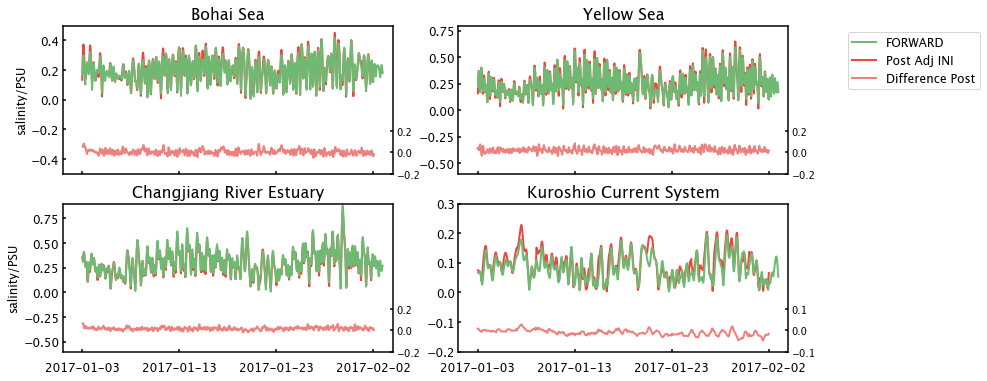

In [70]:
areas = {
         'bh': ('Bohai Sea', [-0.5,0.5]),
        'ys': ('Yellow Sea', [-0.6,0.8]),
        'cre': ('Changjiang River Estuary',[-0.6,0.9]),
        'ks': ('Kuroshio Current System', [-0.2,0.3])
}
#====================================Calculate on observation grid
plt.rcParams['font.family'] = 'Lucida Grande'
# colorarray = cmaps.GMT_haxby.colors[:][:-8]
# nl_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,4)).astype(int)]
# colorarray = cmaps.cmocean_algae.colors[:][50:]
# daa_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,5)).astype(int)]
colorarray =   np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                ])/255
colorarray_blue = np.zeros([256,3])
for i in range(3):
    colorarray_blue[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
dab_color= [colorarray_blue[i,:] for i in np.ceil(np.linspace(0,len(colorarray_blue)-20,4)).astype(int)]

colorarray =   np.array(  [
                 [117,20,12],
                [140,26,17],
                [164,33,21],
                [188,39,26],
                [212,45,31],
                [233,52,37],
                [235,76,67],
                [233,52,37],
                [235,76,67],
                [237,117,113],
                [242,164,162]
                ])/255
colorarray_red = np.zeros([256,3])
for i in range(3):
    colorarray_red[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
daa_color= [colorarray_red[i,:] for i in np.ceil(np.linspace(0,len(colorarray_red)-20,4)).astype(int)]


colorarray_oran = cmaps.MPL_PRGn_r.colors[:63][:]
nl_color= [colorarray_oran[i][:] for i in np.ceil(np.linspace(0,len(colorarray_oran)-20,4)).astype(int)]

# colorarray_pi = cmaps.MPL_PRGn_r.colors[:63][:]
# dab_color= [colorarray_pi[i][:] for i in np.ceil(np.linspace(0,len(colorarray_pi)-1,4)).astype(int)]

iwnl = 0
iwda = 0
# obs_inarea = {}
fig = plt.figure(figsize=(13,6))
fig.tight_layout(pad=5.)
for i, (area, areainfo) in enumerate(areas.items()):
    ax = fig.add_subplot(2,2,i+1)
    
    for bnd in ax.spines.keys():
                            ax.spines[bnd].set_linewidth('1.5')
#     area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
   
#     obs_inarea[area] = np.zeros([30,len(area_index[0])])
    # for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9):
    #     obs_thistime = obs_value[np.where(obs_time == itime)[0]]
    #     obs_inarea[it, :] = obs_thistime[area_index[0]]
    # obs_inarea[area] =   [ obs_value[np.where(obs_time == itime)[0]][area_index[0]] for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9)]
    # l1, =ax.plot(obs_ds.survey_time.data.astype('float')/86400/1e9,np.nanmean(obs_inarea[area],axis=1),linewidth = 2.5,color = 'k',marker= '.',label = 'Observation')
    
#     l3, =ax.plot(dab_UVars[area][iwda].ocean_time,
#                  np.sqrt(np.nanmean(dab_UVars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1))**2 +
#                          np.nanmean(dab_VVars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1))**2),
#                  linewidth = 2, color = dab_color[2], label = 'Prior '+ dab_Workspaces[iwda].workspace_detail)
   
    l4, =ax.plot(daa_UVars[area][iwda].ocean_time,
                 np.sqrt(np.nanmean(daa_UVars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1))**2 +
                         np.nanmean(daa_VVars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1))**2),
                 linewidth = 2, color = daa_color[2], label = 'Post '+ daa_Workspaces[iwda].workspace_detail)
    l2, =ax.plot(nl_UVars[area][iwnl].ocean_time,
                 np.sqrt(np.nanmean(nl_UVars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1))**2 +
                         np.nanmean(nl_VVars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1))**2),
                 linewidth = 2,color = nl_color[2],label = nl_Workspaces[iwnl].workspace_detail)
    ax.set_xticks(daa_UVars[area][iwda].ocean_time[0::240].astype('float')/86400/1e9)
    ax.set_xlim([daa_UVars[area][iwda].ocean_time[0].astype('float')/86400/1e9-2,
                 daa_UVars[area][iwda].ocean_time[-1].astype('float')/86400/1e9+2])
    # ax.tick_params('x',labelbottom=False)
    ax.tick_params(direction = 'in', length = 3, width = 1.5, labelsize = 12)
    # ax.set_ylim([0,8])
    
    if i+1 == 1 or i+1 == 2:
        ax.tick_params('x',labelbottom=False)
    
    ax.tick_params('x',pad=10)
    
    ax.set_title('%s' %areainfo[0],fontsize =16)
    ax.set_ylim(areainfo[1])
    if i +1 ==3 or i+1 ==1: ax.set_ylabel('salinity/PSU',fontsize = 12)
    
    ax1={}
    if i+ 1 == 1:
        ax1[i] = fig.add_axes([0.125,0.537,0.353,0.1])
        ax1[i].set_ylim([-0.2,0.2])
        ax1[i].set_yticks([-0.2,0,0.2])
    elif i+1 ==2:
        ax1[i] = fig.add_axes([0.547,0.537,0.353,0.1])
        ax1[i].set_ylim([-0.2,0.2])
        ax1[i].set_yticks([-0.2,0,0.2])
    elif i+1 ==3:
        ax1[i] = fig.add_axes([0.125,0.125,0.353,0.1])
        ax1[i].set_ylim([-0.2,0.2])
        ax1[i].set_yticks([-0.2,0,0.2])
    elif i+1 ==4:
        ax1[i] = fig.add_axes([0.547,0.125,0.353,0.1])
        ax1[i].set_ylim([-0.1,0.1])
        ax1[i].set_yticks([-0.1,0,0.1])
    
    for bnd in ax1[i].spines.keys():
            ax1[i].spines[bnd].set_visible(False)
    # ax1[i].plot(daa_Vars[area].ocean_time,np.nanmean(daa_Vars[area].val_obsgrd[:,area_index[area][0]],axis=(1))*0,alpha=0)
    # l5, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,
    #                  np.nanmean(onobstime_dnl[area][0],axis=1),
    #                  linewidth =2,color= nl_color[3],marker= '.',label = 'Innovation FORWARD')
    # l6, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,
    #                  np.sqrt(np.nanmean(onobstime_Udab[area][iwda],axis=1)**2+
    #                          np.nanmean(onobstime_Vdab[area][iwda],axis=1)**2)
    #                          -
    #                  np.sqrt(np.nanmean(onobstime_Unl[area][iwda],axis=1)**2+
    #                          np.nanmean(onobstime_Vnl[area][iwda],axis=1)**2),
    #                  linewidth =2,color= dab_color[3],marker= '.',label = 'Difference Prior')
    
    # l6, =ax1[i].plot(dab_UVars[area][iwda].ocean_time[1:],
    #                  np.nanmean(np.sqrt(dab_UVars[area][iwda].value_rotate[1:,:,:]**2 + dab_VVars[area][iwda].value_rotate[1:,:,:]**2)
    #                     -
    #                    np.array(
    #                        [0.5*(
    #                        np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
    #                        +
    #                        np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
    #                        )
    #                        for it in range(1,len(dab_UVars[area][iwda].ocean_time))])
    #                        ,axis=(1,2)),
    #                  linewidth =2,color= dab_color[3],label = 'Difference Prior')
    
    # l7, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,
    #                  np.sqrt(np.nanmean(onobstime_Udaa[area][iwda],axis=1)**2+
    #                          np.nanmean(onobstime_Vdaa[area][iwda],axis=1)**2)
    #                          -
    #                  np.sqrt(np.nanmean(onobstime_Unl[area][iwda],axis=1)**2+
    #                          np.nanmean(onobstime_Vnl[area][iwda],axis=1)**2),
    #                  linewidth =2,color= daa_color[3],marker= '.',label = 'Difference Post')
    
    l7, =ax1[i].plot(daa_UVars[area][iwda].ocean_time[1:],
                     np.nanmean(np.sqrt(daa_UVars[area][iwda].value_rotate[1:,:,:]**2 + daa_VVars[area][iwda].value_rotate[1:,:,:]**2)
                        -
                       np.array(
                           [0.5*(
                           np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
                           +
                           np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
                           )
                           for it in range(1,len(daa_UVars[area][iwda].ocean_time))])
                           ,axis=(1,2)),
                     linewidth =2,color= daa_color[3],label = 'Difference Post')

    ax1[i].tick_params('x',labelbottom=False)
    ax1[i].tick_params('y',labelleft=False,labelright=True)
    ax1[i].tick_params(direction='in',bottom =0, left = 0,right = 1,length = 3, width = 1.5)
    ax1[i].set_xticks(daa_UVars[area][iwda].ocean_time[0::240].astype('float')/86400/1e9)
    ax1[i].set_xlim([daa_UVars[area][iwda].ocean_time[0].astype('float')/86400/1e9-2,
                 daa_UVars[area][iwda].ocean_time[-1].astype('float')/86400/1e9+2])
    ax1[i].set_facecolor('none')
    if i+1 ==1 : ax.legend(bbox_to_anchor=(2.8, 1.0),handles=[l2,l4,l7],fontsize=12)
    # if i +1 ==2 or i+1 ==4: ax1[i].set_ylabel('temp/$\degree$C')
    plt.savefig('./fig_evolution/exp_adj_ini/post/ssvel/roms_i4dvar_contrast_sss_adj_ini.jpeg',dpi=1200,bbox_inches='tight')
# plt.savefig('roms_i4dvar_valid_obsgrd_adj_ini.pdf',bbox_inches='tight')
# plt.savefig('roms_i4dvar_valid_obsgrd_adj_all.jpeg',dpi=1200,bbox_inches='tight')

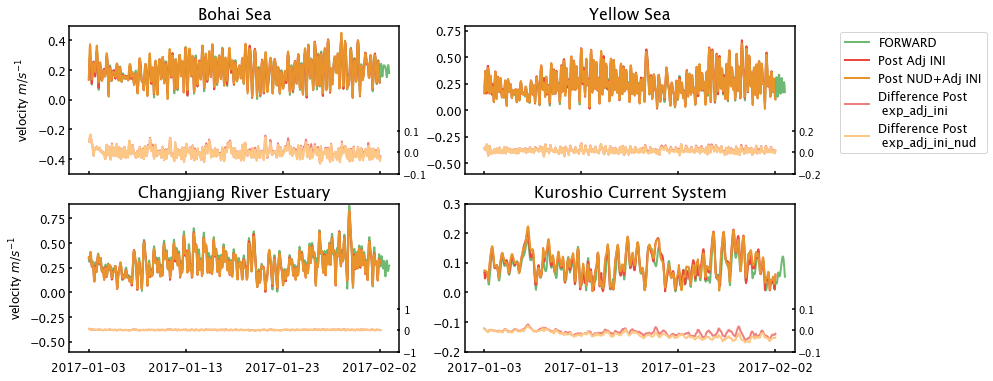

In [79]:
areas = {
         'bh': ('Bohai Sea', [-0.5,0.5]),
        'ys': ('Yellow Sea', [-0.6,0.8]),
        'cre': ('Changjiang River Estuary',[-0.6,0.9]),
        'ks': ('Kuroshio Current System', [-0.2,0.3])
}
#=================================
#====================================Calculate on observation grid
plt.rcParams['font.family'] = 'Lucida Grande'
# colorarray = cmaps.GMT_haxby.colors[:][:-8]
# nl_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,4)).astype(int)]
# colorarray = cmaps.cmocean_algae.colors[:][50:]
# daa_color= [colorarray[:][i] for i in np.ceil(np.linspace(0,len(colorarray)-1,5)).astype(int)]
colorarray =   np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                ])/255
colorarray_blue = np.zeros([256,3])
for i in range(3):
    colorarray_blue[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
dab_color= [colorarray_blue[i,:] for i in np.ceil(np.linspace(0,len(colorarray_blue)-20,4)).astype(int)]

colorarray =   np.array(  [
                 [117,20,12],
                [140,26,17],
                [164,33,21],
                [188,39,26],
                [212,45,31],
                [233,52,37],
                [235,76,67],
                [233,52,37],
                [235,76,67],
                [237,117,113],
                [242,164,162]
                ])/255
colorarray_red = np.zeros([256,3])
for i in range(3):
    colorarray_red[:,i] = np.interp(np.linspace(0,1,256), 
                                     np.linspace(0,1,len(colorarray)), 
                                     colorarray[:,i].T
                                    )
daa_color= [colorarray_red[i,:] for i in np.ceil(np.linspace(0,len(colorarray_red)-20,4)).astype(int)]

colorarray_oran = cmaps.MPL_PuOr.colors[:63][:]
daa2_color= [colorarray_oran[i][:] for i in np.ceil(np.linspace(0,len(colorarray_oran)-20,4)).astype(int)]
colorarray_oran = cmaps.MPL_PRGn_r.colors[:63][:]
nl_color= [colorarray_oran[i][:] for i in np.ceil(np.linspace(0,len(colorarray_oran)-20,4)).astype(int)]

# colorarray_pi = cmaps.MPL_PRGn_r.colors[:63][:]
# dab_color= [colorarray_pi[i][:] for i in np.ceil(np.linspace(0,len(colorarray_pi)-1,4)).astype(int)]

iwnl = 0
iwda = 0
iwda1 =2
# obs_inarea = {}
fig = plt.figure(figsize=(13,6))
fig.tight_layout(pad=5.)
for i, (area, areainfo) in enumerate(areas.items()):
    ax = fig.add_subplot(2,2,i+1)
    
    for bnd in ax.spines.keys():
                            ax.spines[bnd].set_linewidth('1.5')
#     area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
   
#     obs_inarea[area] = np.zeros([30,len(area_index[0])])
    # for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9):
    #     obs_thistime = obs_value[np.where(obs_time == itime)[0]]
    #     obs_inarea[it, :] = obs_thistime[area_index[0]]
    # obs_inarea[area] =   [ obs_value[np.where(obs_time == itime)[0]][area_index[0]] for it,itime in enumerate(obs_ds.survey_time.data.astype('float')/86400/1e9)]
    # l1, =ax.plot(obs_ds.survey_time.data.astype('float')/86400/1e9,np.nanmean(obs_inarea[area],axis=1),linewidth = 2.5,color = 'k',marker= '.',label = 'Observation')
    l2, =ax.plot(nl_UVars[area][iwnl].ocean_time,
                 np.sqrt(np.nanmean(nl_UVars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1))**2 +
                         np.nanmean(nl_VVars[area][iwnl].val_obsgrd[:,area_index[area][0]],axis=(1))**2),
                 linewidth = 2,color = nl_color[2],label = nl_Workspaces[iwnl].workspace_detail)
    l3, =ax.plot(dab_UVars[area][iwda].ocean_time,
                 np.sqrt(np.nanmean(dab_UVars[area][iwda].val_obsgrd[:,area_index[area][0]],axis=(1))**2 +
                         np.nanmean(dab_VVars[area][iwda].val_obsgrd[:,area_index[area][0]],axis=(1))**2),
                 linewidth = 2, color = daa_color[2], label = 'Post '+ daa_Workspaces[iwda].workspace_detail)
   
    l4, =ax.plot(daa_UVars[area][iwda1].ocean_time,
                np.sqrt(np.nanmean(daa_UVars[area][iwda1].val_obsgrd[:,area_index[area][0]],axis=(1))**2 +
                         np.nanmean(daa_VVars[area][iwda1].val_obsgrd[:,area_index[area][0]],axis=(1))**2),
                 linewidth = 2, color = daa2_color[2], label = 'Post '+ daa_Workspaces[iwda1].workspace_detail)
   
    ax.set_xticks(daa_UVars[area][iwda].ocean_time[0::240].astype('float')/86400/1e9)
    ax.set_xlim([daa_UVars[area][iwda].ocean_time[0].astype('float')/86400/1e9-2,
                 daa_UVars[area][iwda].ocean_time[-1].astype('float')/86400/1e9+2])
    # ax.tick_params('x',labelbottom=False)
    ax.tick_params(direction = 'in', length = 3, width = 1.5, labelsize = 12)
    # ax.set_ylim([0,8])
    
    if i+1 == 1 or i+1 == 2:
        ax.tick_params('x',labelbottom=False)
    
    ax.tick_params('x',pad=10)
    
    ax.set_title('%s' %areainfo[0],fontsize =16)
    ax.set_ylim(areainfo[1])
    if i +1 ==3 or i+1 ==1: ax.set_ylabel('velocity $m/s^{-1}$',fontsize = 12)
    
    ax1={}
    if i+ 1 == 1:
        ax1[i] = fig.add_axes([0.125,0.537,0.353,0.1])
        ax1[i].set_ylim([-0.1,0.1])
        ax1[i].set_yticks([-0.1,0,0.1])
    elif i+1 ==2:
        ax1[i] = fig.add_axes([0.547,0.537,0.353,0.1])
        ax1[i].set_ylim([-0.2,0.2])
        ax1[i].set_yticks([-0.2,0,0.2])
    elif i+1 ==3:
        ax1[i] = fig.add_axes([0.125,0.125,0.353,0.1])
        ax1[i].set_ylim([-1,1])
        ax1[i].set_yticks([-1,0,1])
    elif i+1 ==4:
        ax1[i] = fig.add_axes([0.547,0.125,0.353,0.1])
        ax1[i].set_ylim([-0.1,0.1])
        ax1[i].set_yticks([-0.1,0,0.1])
    
    for bnd in ax1[i].spines.keys():
            ax1[i].spines[bnd].set_visible(False)
    # ax1[i].plot(daa_Vars[area].ocean_time,np.nanmean(daa_Vars[area].val_obsgrd[:,area_index[area][0]],axis=(1))*0,alpha=0)
    # l5, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,
    #                  np.nanmean(onobstime_dnl[area][0],axis=1),
    #                  linewidth =2,color= nl_color[3],marker= '.',label = 'Innovation FORWARD')
    # l6, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,
    #                  np.nanmean(onobstime_dab[area][iwda],axis=1)-
    #                  np.nanmean(onobstime_nl[area][iwnl],axis=1),
    #                  linewidth =2,color= dab_color[3],marker= '.',label = 'Difference Prior')
   
    # l7, =ax1[i].plot(obs_ds.survey_time.data.astype('float')/86400/1e9,
    #                  np.nanmean(onobstime_daa[area][iwda],axis=1)-
    #                  np.nanmean(onobstime_nl[area][iwnl],axis=1),
    #                  linewidth =2,color= daa_color[3],marker= '.',label = 'Difference Post')
    
    l6, =ax1[i].plot(daa_UVars[area][iwda].ocean_time[1:],
                     np.nanmean(np.sqrt(daa_UVars[area][iwda].value_rotate[1:,:,:]**2 + daa_VVars[area][iwda].value_rotate[1:,:,:]**2)
                        -
                       np.array(
                           [0.5*(
                           np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
                           +
                           np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
                           )
                           for it in range(1,len(daa_UVars[area][iwda].ocean_time))])
                           ,axis=(1,2)),
                     linewidth =2,color= daa_color[3],label = 'Difference Post \n exp_adj_ini')
   
    l7, =ax1[i].plot(daa_UVars[area][iwda1].ocean_time[1:],
                     np.nanmean(np.sqrt(daa_UVars[area][iwda1].value_rotate[1:,:,:]**2 + daa_VVars[area][iwda1].value_rotate[1:,:,:]**2)
                        -
                       np.array(
                           [0.5*(
                           np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
                           +
                           np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
                           )
                           for it in range(1,len(daa_UVars[area][iwda1].ocean_time))])
                           ,axis=(1,2)),
                     linewidth =2,color= daa2_color[3],label = 'Difference Post \n exp_adj_ini_nud')
    # l7, =ax1[i].plot(daa_UVars[area][iwda1].ocean_time[:709],
    #                  np.nanmean(np.sqrt(daa_UVars[area][iwda1].value_rotate[:709,:,:]**2 + daa_VVars[area][iwda1].value_rotate[:709,:,:]**2)
    #                     -
    #                    np.array(
    #                        [0.5*(
    #                        np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
    #                        +
    #                        np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
    #                        )
    #                        for it in range(12,len(daa_UVars[area][iwda].ocean_time))])
    #                        ,axis=(1,2)),
    #                  linewidth =2,color= daa2_color[3],label = 'Difference Post \n exp_adj_ini_b12hr')
    # l7, =ax1[i].plot(daa_Vars[area][iwda1].ocean_time[:710],
    #                  np.nanmean(daa_Vars[area][iwda1].value[:710,:,:]-
    #                        np.array(
    #                            [0.5*(nl_Vars[area][iwnl].value[it,:,:]+nl_Vars[area][iwnl].value[it-1,:,:]) 
    #                             for it in range(11,len(daa_Vars[area][iwda].ocean_time))]) ,axis = (1,2)
    #                                ),
    #                  linewidth =2,color= daa2_color[3],label = 'Difference Post \n exp_adj_ini_b12hr')
      

    ax1[i].tick_params('x',labelbottom=False)
    ax1[i].tick_params('y',labelleft=False,labelright=True)
    ax1[i].tick_params(direction='in',bottom =0, left = 0,right = 1,length = 3, width = 1.5)
    ax1[i].set_xticks(daa_UVars[area][iwda].ocean_time[0::240].astype('float')/86400/1e9)
    ax1[i].set_xlim([daa_UVars[area][iwda].ocean_time[0].astype('float')/86400/1e9-2,
                 daa_UVars[area][iwda].ocean_time[-1].astype('float')/86400/1e9+2])
    ax1[i].set_facecolor('none')
    if i+1 ==1 : ax.legend(bbox_to_anchor=(2.8, 1.0),handles=[l2,l3,l4,l6,l7],fontsize=12)
plt.savefig('./fig_contrast/adj_ini.vs.adj_ini_nud/post/ssvel/roms_i4dvar_valid_obsgrd_adj_ini.vs.nud+ini.jpeg',dpi=1200,bbox_inches='tight')
    # if i +1 ==2 or i+1 ==4: ax1[i].set_ylabel('temp/$\degree$C')
# plt.savefig('roms_i4dvar_valid_obsgrd_adj_ini.pdf',bbox_inches='tight')
# plt.savefig('./fig_contrast/adj_ini.vs.adj_ini_nud/post/ssvel/roms_i4dvar_valid_obsgrd_adj_ini.vs.nud+ini.jpeg',dpi=1200,bbox_inches='tight')
# plt.savefig('./fig_evolution/exp_adj_ini/post/sss/roms_i4dvar_contrast_sss_adj_ini.jpeg',dpi=1200,bbox_inches='tight')

In [76]:
# nl_UVars[area][iwda].ocean_time[-1]
daa_UVars[area][iwda].value.shape

(721, 109, 78)

In [11]:

lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_vel_color = cmaps.cmocean_balance.colors[128:][:]
my_vel = LinearSegmentedColormap.from_list('vel',my_vel_color, N = 256)

#
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)
figsize = (11,5)

d_interval = 0.1
iwnl = 0
iwda = 1
plt.rcParams['font.family'] = 'Lucida Grande'
area = 'ks'
# for area in ['bh','ys','cre','ks','all']:
for area in ['all',]:
    if area == 'bh':
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 15
        
        bc = 0.98
    elif area == 'ys':
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vec_interval = 8
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        bc = 0.965
    elif area == 'ks':
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        
        lon_interval = 4
        lat_interval = 3
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.965
    elif area =='all':
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];

        lon_interval = 5
        lat_interval = 5
        vec_interval = 10
        vmin_sst = 0
        vmax_sst = 1.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.93
    for it in range(1,len(daa_UVars[area][iwda].ocean_time)):
    # for it in range(1,3):
        
        fig = plt.figure(figsize=figsize, constrained_layout = True)
        #===============================observation spatial pattern
        ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        # ax.tick_params('x',labelbottom=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
        ax.pcolormesh(nl_UVars[area][iwnl].lon,nl_UVars[area][iwnl].lat,
                       0.5*(
                               np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
                               +
                               np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
                           ),
                   cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.quiver(nl_UVars[area][iwnl].lon[::vec_interval,::vec_interval],nl_UVars[area][iwnl].lat[::vec_interval,::vec_interval],
                  0.5*(nl_UVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval]+nl_UVars[area][iwnl].value_rotate[it-1,::vec_interval,::vec_interval]),
                  0.5*(nl_VVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval]+nl_VVars[area][iwnl].value_rotate[it-1,::vec_interval,::vec_interval]), 
                  scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
                               transform = ccrs.PlateCarree())
        ax.set_title('Forward',fontsize=16)
        ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(daa_UVars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(daa_UVars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
        #===============================posterior spatial pattern
        ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)

        c2=ax.pcolormesh(daa_UVars[area][iwda].lon,daa_UVars[area][iwda].lat,
                       np.sqrt(daa_UVars[area][iwda].value_rotate[it,:,:]**2 + daa_VVars[area][iwda].value_rotate[it,:,:]**2),
                   cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.quiver(daa_UVars[area][iwnl].lon[::vec_interval,::vec_interval],daa_UVars[area][iwnl].lat[::vec_interval,::vec_interval],
                  daa_UVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval],
                  daa_VVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval], 
                  scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
                               transform = ccrs.PlateCarree())
        ax.set_title('Posterior exp_adj_ini_nud',fontsize=16)

                #==== colobar
        
        position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
        cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        cb.set_label('$m/s^{-1}$',fontsize = 12) 
        #===============================innovation spatial pattern
        ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        cb3 = ax.pcolormesh(daa_UVars[area][iwda].lon,daa_UVars[area][iwda].lat,
                       np.sqrt(daa_UVars[area][iwda].value_rotate[it,:,:]**2 + daa_VVars[area][iwda].value_rotate[it,:,:]**2)
                            -
                           0.5*(
                               np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
                               +
                               np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
                           ),
                   cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Difference',fontsize=16)
            #---- colrbar
        
        position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


        cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        cb2.set_label('$m/s^{-1}$',fontsize = 12) 
        # fig.colorbar(c3)
        # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

        # fig = plt.figure(figsize=figsize, constrained_layout = True)

        #===============================observation spatial pattern
#         
        plt.savefig('./fig_evolution/exp_adj_ini_nud/post/ssvel/%s/%s.jpeg'%(area,str(it)),dpi=300,bbox_inches='tight')
        plt.close()

/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anacond

In [25]:

lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_vel_color = cmaps.cmocean_balance.colors[128:][:]
my_vel = LinearSegmentedColormap.from_list('vel',my_vel_color, N = 256)

#
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)
figsize = (11,5)

d_interval = 0.1
iwnl = 3
iwda = 2
plt.rcParams['font.family'] = 'Lucida Grande'
area = 'ks'
# for area in ['bh','ys','cre','ks','all']:
for area in ['all',]:
    if area == 'bh':
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 15
        
        bc = 0.98
    elif area == 'ys':
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vec_interval = 8
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        bc = 0.965
    elif area == 'ks':
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        
        lon_interval = 4
        lat_interval = 3
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.965
    elif area =='all':
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];

        lon_interval = 5
        lat_interval = 5
        vec_interval = 10
        vmin_sst = 0
        vmax_sst = 1.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.93
    # for it in range(1,len(dab_UVars[area][iwda].ocean_time)):
    for it in range(1,50):
        
        fig = plt.figure(figsize=figsize, constrained_layout = True)
        #===============================observation spatial pattern
        ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        # ax.tick_params('x',labelbottom=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
        ax.pcolormesh(nl_UVars[area][iwnl].lon,nl_UVars[area][iwnl].lat,
                       0.5*(
                               np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
                               +
                               np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
                           ),
                   cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.quiver(nl_UVars[area][iwnl].lon[::vec_interval,::vec_interval],nl_UVars[area][iwnl].lat[::vec_interval,::vec_interval],
                  0.5*(nl_UVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval]+nl_UVars[area][iwnl].value_rotate[it-1,::vec_interval,::vec_interval]),
                  0.5*(nl_VVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval]+nl_VVars[area][iwnl].value_rotate[it-1,::vec_interval,::vec_interval]), 
                  scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
                               transform = ccrs.PlateCarree())
        ax.set_title('Forward',fontsize=16)
        ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(dab_UVars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(dab_UVars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
        #===============================posterior spatial pattern
        ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)

        c2=ax.pcolormesh(dab_UVars[area][iwda].lon,dab_UVars[area][iwda].lat,
                       np.sqrt(dab_UVars[area][iwda].value_rotate[it,:,:]**2 + dab_VVars[area][iwda].value_rotate[it,:,:]**2),
                   cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.quiver(dab_UVars[area][iwda].lon[::vec_interval,::vec_interval],dab_UVars[area][iwda].lat[::vec_interval,::vec_interval],
                  dab_UVars[area][iwda].value_rotate[it,::vec_interval,::vec_interval],
                  dab_VVars[area][iwda].value_rotate[it,::vec_interval,::vec_interval], 
                  scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
                               transform = ccrs.PlateCarree())
        ax.set_title('Prior exp_adj_ini_nud_ffile',fontsize=16)

                #==== colobar
        
        position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
        cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        cb.set_label('$m/s^{-1}$',fontsize = 12) 
        #===============================innovation spatial pattern
        ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
#         cb3 = ax.pcolormesh(dab_UVars[area][iwda].lon,dab_UVars[area][iwda].lat,
#                        np.sqrt(dab_UVars[area][iwda].value_rotate[it,:,:]**2 + dab_VVars[area][iwda].value_rotate[it,:,:]**2)
#                             -
#                            0.5*(
#                                np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
#                                +
#                                np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
#                            ),
#                    cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,
                   
#                    transform = ccrs.PlateCarree(),zorder = -1)
        cb3 = ax.pcolormesh(dab_UVars[area][iwda].lon,dab_UVars[area][iwda].lat,
                       np.sqrt(dab_UVars[area][iwda].value_rotate[it,:,:]**2 + dab_VVars[area][iwda].value_rotate[it,:,:]**2)
                            -
                           
                        np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2 + nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
                               
                           ,
                   cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Difference',fontsize=16)
            #---- colrbar
        
        position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


        cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        cb2.set_label('$m/s^{-1}$',fontsize = 12) 
        # fig.colorbar(c3)
        # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

        # fig = plt.figure(figsize=figsize, constrained_layout = True)

        #===============================observation spatial pattern
#         
        plt.savefig('./fig_evolution/exp_adj_ini_nud_ffile/prior/ssvel/%s/%s.jpeg'%(area,str(it)),dpi=300,bbox_inches='tight')
        plt.close()

/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anacond

/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_23650/3342592561.py:142: RuntimeWarning: Mean of empty slice
  np.nanmean(
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_23650/3342592561.py:176: RuntimeWarning: Mean of empty slice
  np.nanmean(
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_23650/3342592561.py:233: RuntimeWarning: Mean of empty slice
  np.nanmean(np.sqrt(daa_UVars[area][iwda].value_rotate[1:,:,:]**2 + daa_VVars[area][iwda].value_rotate[1:,:,:]**2)
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


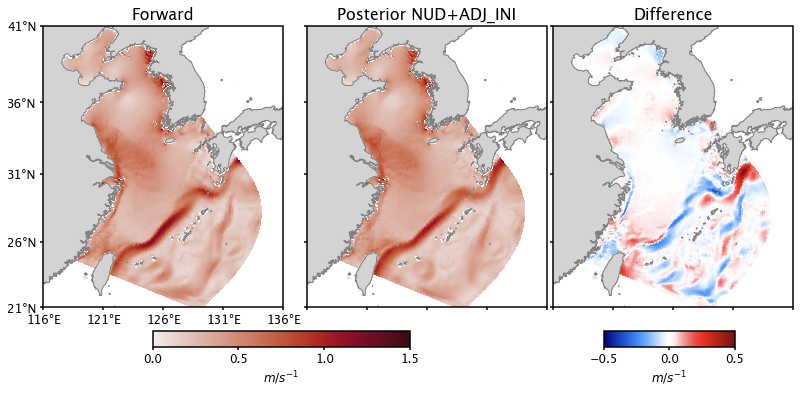

In [34]:
#=======time-averaged difference

lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_vel_color = cmaps.cmocean_balance.colors[128:][:]
my_vel = LinearSegmentedColormap.from_list('vel',my_vel_color, N = 256)

#
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)


d_interval = 0.1
iwnl = 3
iwda = 2
plt.rcParams['font.family'] = 'Lucida Grande'

# for area in ['bh','ys','cre','ks','all']:
for area in ['all',]:
    if area == 'bh':
        figsize = (11,4)
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 15
        
        bc = 0.98
    elif area == 'ys':
        figsize = (11,4)
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        figsize = (11,4)
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vec_interval = 8
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        bc = 0.965
    elif area == 'ks':
        figsize = (11,4)
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        
        lon_interval = 4
        lat_interval = 3
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.965
    elif area =='all':
        figsize = (11,5)
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];

        lon_interval = 5
        lat_interval = 5
        vec_interval = 10
        vmin_sst = 0
        vmax_sst = 1.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.93
    
    # for it in range(1,3):
        
    fig = plt.figure(figsize=figsize, constrained_layout = True)
    #===============================observation spatial pattern
    ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    # ax.tick_params('x',labelbottom=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
    ax.pcolormesh(nl_UVars[area][iwnl].lon,nl_UVars[area][iwnl].lat,
                   np.nanmean(
                           np.sqrt(nl_UVars[area][iwnl].value_rotate**2+nl_VVars[area][iwnl].value_rotate**2)
                       , axis =0 ),
               cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,

               transform = ccrs.PlateCarree(),zorder = -1)
    # ax.quiver(nl_UVars[area][iwnl].lon[::vec_interval,::vec_interval],nl_UVars[area][iwnl].lat[::vec_interval,::vec_interval],
    #           0.5*(nl_UVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval]+nl_UVars[area][iwnl].value_rotate[it-1,::vec_interval,::vec_interval]),
    #           0.5*(nl_VVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval]+nl_VVars[area][iwnl].value_rotate[it-1,::vec_interval,::vec_interval]), 
    #           scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
    #                        transform = ccrs.PlateCarree())
    ax.set_title('Forward',fontsize=16)
    # ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(daa_UVars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(daa_UVars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
    #===============================posterior spatial pattern
    ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)

    c2=ax.pcolormesh(daa_UVars[area][iwda].lon,daa_UVars[area][iwda].lat,
                   np.nanmean(
                       np.sqrt(daa_UVars[area][iwda].value_rotate**2 + daa_VVars[area][iwda].value_rotate**2),
                   axis=0),
               cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,

               transform = ccrs.PlateCarree(),zorder = -1)
    # ax.quiver(daa_UVars[area][iwnl].lon[::vec_interval,::vec_interval],daa_UVars[area][iwnl].lat[::vec_interval,::vec_interval],
    #           daa_UVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval],
    #           daa_VVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval], 
    #           scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
    #                        transform = ccrs.PlateCarree())
    ax.set_title('Posterior NUD+ADJ_INI',fontsize=16)

            #==== colobar

    position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
    cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
    for bnd in position.spines.keys():
            position.spines[bnd].set_linewidth('1.5')
    position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

    cb.set_label('$m/s^{-1}$',fontsize = 12) 
    #===============================innovation spatial pattern
    ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
#     cb3 = ax.pcolormesh(daa_UVars[area][iwda].lon,daa_UVars[area][iwda].lat,
#                    np.nanmean(np.sqrt(daa_UVars[area][iwda].value_rotate[1:,:,:]**2 + daa_VVars[area][iwda].value_rotate[1:,:,:]**2)
#                         -
#                        np.array(
#                            [0.5*(
#                            np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
#                            +
#                            np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
#                            )
#                            for it in range(1,len(daa_UVars[area][iwda].ocean_time))])
#                            ,axis=0),
#                cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,

#                transform = ccrs.PlateCarree(),zorder = -1)
    cb3 = ax.pcolormesh(daa_UVars[area][iwda].lon,daa_UVars[area][iwda].lat,
                   np.nanmean(np.sqrt(daa_UVars[area][iwda].value_rotate[1:,:,:]**2 + daa_VVars[area][iwda].value_rotate[1:,:,:]**2)
                        -
                      np.sqrt(nl_UVars[area][iwnl].value_rotate[:720,:,:]**2 + nl_VVars[area][iwnl].value_rotate[:720,:,:]**2)
                           ,axis=0),
               cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,

               transform = ccrs.PlateCarree(),zorder = -1)
    ax.set_title('Difference',fontsize=16)
        #---- colrbar

    position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


    cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
    for bnd in position.spines.keys():
            position.spines[bnd].set_linewidth('1.5')
    position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
    cb2.set_label('$m/s^{-1}$',fontsize = 12) 
    # fig.colorbar(c3)
    # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

    # fig = plt.figure(figsize=figsize, constrained_layout = True)

    #===============================observation spatial pattern
#         
    plt.savefig('./fig_evolution/exp_adj_ini_nud/post/ssvel/%s_roms_i4dvar_contrast_adj_ini_nud_forw.vs.post_timemean2.jpeg'%(area),dpi=1200,bbox_inches='tight')
    # plt.savefig('./fig_evolution/post/ssvel/%s/%s.jpeg'%(area,str(it)),dpi=300,bbox_inches='tight')
    # plt.close()

/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_23650/4161203670.py:142: RuntimeWarning: Mean of empty slice
  np.nanmean(0.5*(
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_23650/4161203670.py:180: RuntimeWarning: Mean of empty slice
  np.nanmean(0.5*(
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_23650/4161203670.py:247: RuntimeWarning: Mean of empty slice
  np.nanmean(np.array(
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


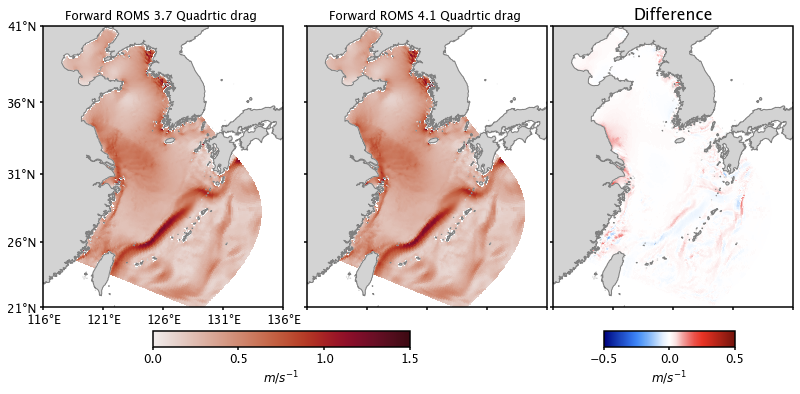

In [35]:
#=======time-averaged difference

lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_vel_color = cmaps.cmocean_balance.colors[128:][:]
my_vel = LinearSegmentedColormap.from_list('vel',my_vel_color, N = 256)

#
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)


d_interval = 0.1
iwnl = 0
iwda = 3
plt.rcParams['font.family'] = 'Lucida Grande'

# for area in ['bh','ys','cre','ks','all']:
for area in ['all',]:
    if area == 'bh':
        figsize = (11,4)
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 15
        
        bc = 0.98
    elif area == 'ys':
        figsize = (11,4)
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        figsize = (11,4)
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vec_interval = 8
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        bc = 0.965
    elif area == 'ks':
        figsize = (11,4)
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        
        lon_interval = 4
        lat_interval = 3
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.965
    elif area =='all':
        figsize = (11,5)
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];

        lon_interval = 5
        lat_interval = 5
        vec_interval = 10
        vmin_sst = 0
        vmax_sst = 1.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.93
    
    # for it in range(1,3):
        
    fig = plt.figure(figsize=figsize, constrained_layout = True)
    #===============================observation spatial pattern
    ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    # ax.tick_params('x',labelbottom=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
    # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
    ax.pcolormesh(nl_UVars[area][iwnl].lon,nl_UVars[area][iwnl].lat,
                   np.nanmean(0.5*(
                           np.sqrt(nl_UVars[area][iwnl].value_rotate**2+nl_VVars[area][iwnl].value_rotate**2)
                           +
                           np.sqrt(nl_UVars[area][iwnl].value_rotate**2+nl_VVars[area][iwnl].value_rotate**2)
                       ), axis =0 ),
               cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,

               transform = ccrs.PlateCarree(),zorder = -1)
    # ax.quiver(nl_UVars[area][iwnl].lon[::vec_interval,::vec_interval],nl_UVars[area][iwnl].lat[::vec_interval,::vec_interval],
    #           0.5*(nl_UVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval]+nl_UVars[area][iwnl].value_rotate[it-1,::vec_interval,::vec_interval]),
    #           0.5*(nl_VVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval]+nl_VVars[area][iwnl].value_rotate[it-1,::vec_interval,::vec_interval]), 
    #           scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
    #                        transform = ccrs.PlateCarree())
    # ax.set_title('Forward ROMS 3.7  Log Drag',fontsize=16)
    # ax.set_title('Forward ROMS 3.7 Quadrtic drag ',fontsize=12)
    ax.set_title('Forward ROMS 3.7 Quadrtic drag ',fontsize=12)
    # ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(daa_UVars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(daa_UVars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
    #===============================posterior spatial pattern
    ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)

    c2=ax.pcolormesh(nl_UVars[area][iwda].lon,nl_UVars[area][iwda].lat,
                   np.nanmean(0.5*(
                           np.sqrt(nl_UVars[area][iwda].value_rotate**2+nl_VVars[area][iwda].value_rotate**2)
                           +
                           np.sqrt(nl_UVars[area][iwda].value_rotate**2+nl_VVars[area][iwda].value_rotate**2)
                       ), axis =0 ),
               cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,

               transform = ccrs.PlateCarree(),zorder = -1)
    # ax.quiver(daa_UVars[area][iwnl].lon[::vec_interval,::vec_interval],daa_UVars[area][iwnl].lat[::vec_interval,::vec_interval],
    #           daa_UVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval],
    #           daa_VVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval], 
    #           scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
    #                        transform = ccrs.PlateCarree())
    # ax.set_title('Forward ROMS 3.7 Quadrtic drag no correction ',fontsize=12)
    ax.set_title('Forward ROMS 4.1 Quadrtic drag ',fontsize=12)
    # ax.set_title('Forward ROMS 4.1 Quadrtic drag no correction',fontsize=12)

            #==== colobar

    position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
    cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
    for bnd in position.spines.keys():
            position.spines[bnd].set_linewidth('1.5')
    position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

    cb.set_label('$m/s^{-1}$',fontsize = 12) 
    #===============================innovation spatial pattern
    ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('1.5')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
    ax.tick_params('x',labelbottom=False)
    ax.tick_params('y',labelleft=False)
    # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
#     cb3 = ax.pcolormesh(nl_UVars[area][iwda].lon,nl_UVars[area][iwda].lat,
#                    np.nanmean(np.array(
#                            [0.5*(
#                            np.sqrt(nl_UVars[area][iwda].value_rotate[it,:,:]**2+nl_VVars[area][iwda].value_rotate[it,:,:]**2)
#                            +
#                            np.sqrt(nl_UVars[area][iwda].value_rotate[it-1,:,:]**2+nl_VVars[area][iwda].value_rotate[it-1,:,:]**2)
#                            )
#                            for it in range(1,len(daa_UVars[area][0].ocean_time))])
#                         -
#                        np.array(
#                            [0.5*(
#                            np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
#                            +
#                            np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
#                            )
#                            for it in range(1,len(daa_UVars[area][0].ocean_time))])
#                            ,axis=0),
#                cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,

#                transform = ccrs.PlateCarree(),zorder = -1)
    cb3 = ax.pcolormesh(nl_UVars[area][iwda].lon,nl_UVars[area][iwda].lat,
                   np.nanmean(np.array(
                           [
                           np.sqrt(nl_UVars[area][iwda].value_rotate[it,:,:]**2+nl_VVars[area][iwda].value_rotate[it,:,:]**2)
                           
                           for it in range(0,len(daa_UVars[area][0].ocean_time)-1)])
                        -
                       np.array(
                           [0.5*(
                           np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
                           +
                           np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
                           )
                           for it in range(1,len(daa_UVars[area][0].ocean_time))])
                           ,axis=0),
               cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,

               transform = ccrs.PlateCarree(),zorder = -1)
    ax.set_title('Difference',fontsize=16)
        #---- colrbar

    position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


    cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
    for bnd in position.spines.keys():
            position.spines[bnd].set_linewidth('1.5')
    position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
    cb2.set_label('$m/s^{-1}$',fontsize = 12) 
    # fig.colorbar(c3)
    # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

    # fig = plt.figure(figsize=figsize, constrained_layout = True)

    #===============================observation spatial pattern
#         
    plt.savefig('./fig_contrast/roms4.1_qrad_nocorr-roms_3.7_log/diff_timemean1.jpeg',dpi=1200,bbox_inches='tight')
    # plt.savefig('./fig_evolution/post/ssvel/%s/%s.jpeg'%(area,str(it)),dpi=300,bbox_inches='tight')
    # plt.close()

In [ ]:
nl_UVars

In [ ]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import scipy.io as sio
import cmaps
from matplotlib.colors import LinearSegmentedColormap

vec_interval = 10
ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('1.5')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f',
                                degree_symbol='°',
                                dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                    degree_symbol='°')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
ax.tick_params('x',labelbottom=False)
ax.tick_params('y',labelleft=False)

c2=ax.pcolormesh(daa_UVars[area][iwda].lon,daa_UVars[area][iwda].lat,
               np.nanmean(
                   np.sqrt(daa_UVars[area][iwda1].value_rotate**2 + daa_VVars[area][iwda1].value_rotate**2),
               axis=0),
           cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,

           transform = ccrs.PlateCarree(),zorder = -1)
ax.quiver(daa_UVars[area][iwnl].lon[::vec_interval,::vec_interval],daa_UVars[area][iwnl].lat[::vec_interval,::vec_interval],
          daa_UVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval],
          daa_VVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval], 
          scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
                       transform = ccrs.PlateCarree())
ax.set_title('****',fontsize=16)



position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
for bnd in position.spines.keys():
        position.spines[bnd].set_linewidth('1.5')
position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

cb.set_label('$m/s^{-1}$',fontsize = 12) 


plt.savefig('./fig.jpeg'%(area),dpi=1200,bbox_inches='tight')


/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_23650/1619634209.py:143: RuntimeWarning: Mean of empty slice
  np.nanmean(
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_23650/1619634209.py:177: RuntimeWarning: Mean of empty slice
  np.nanmean(
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_23650/1619634209.py:220: RuntimeWarning: Mean of empty slice
  np.nanmean(np.sqrt(daa_UVars[area][iwda1].value_rotate[1:,:,:]**2 + daa_VVars[area][iwda1].value_rotate[1:,:,:]**2)
/var/folders/1q/hs896xlj3djcy9rs8_c7zdmc0000gn/T/ipykernel_23650/1619634209.py:223: RuntimeWarning: Mean of empty slice
  np.nanmean(np.sqrt(daa_UVars[area][iwda].value_rotate[1:,:,:]**2 + daa_VVars[area][iwda].value_rotate[1:,:,:]**2)
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


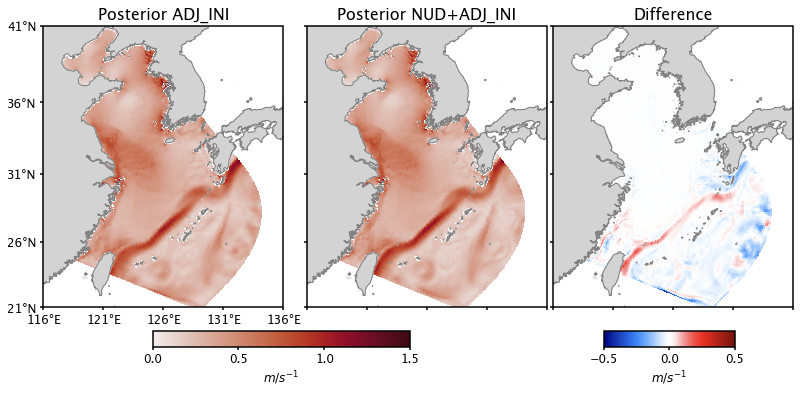

In [27]:
#=======time-averaged difference

lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_vel_color = cmaps.cmocean_balance.colors[128:][:]
my_vel = LinearSegmentedColormap.from_list('vel',my_vel_color, N = 256)

#
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)


d_interval = 0.1
iwnl = 0
iwda = 0
iwda1 = 2
plt.rcParams['font.family'] = 'Lucida Grande'


        
fig = plt.figure(figsize=figsize, constrained_layout = True)
#===============================observation spatial pattern
ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('1.5')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f',
                                degree_symbol='°',
                                dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                    degree_symbol='°')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
# ax.tick_params('x',labelbottom=False)

ax.pcolormesh(nl_UVars[area][iwnl].lon,nl_UVars[area][iwnl].lat,
               np.nanmean(
                   np.sqrt(daa_UVars[area][iwda].value_rotate**2 + daa_VVars[area][iwda].value_rotate**2),
               axis=0),
           cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,

           transform = ccrs.PlateCarree(),zorder = -1)
ax.quiver(nl_UVars[area][iwnl].lon[::vec_interval,::vec_interval],nl_UVars[area][iwnl].lat[::vec_interval,::vec_interval],
          0.5*(nl_UVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval]+nl_UVars[area][iwnl].value_rotate[it-1,::vec_interval,::vec_interval]),
          0.5*(nl_VVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval]+nl_VVars[area][iwnl].value_rotate[it-1,::vec_interval,::vec_interval]), 
          scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
                       transform = ccrs.PlateCarree())
ax.set_title('Posterior ADJ_INI',fontsize=16)

ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
for bnd in ax.spines.keys():
    ax.spines[bnd].set_linewidth('1.5')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.0f',
                                degree_symbol='°',
                                dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                    degree_symbol='°')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
ax.tick_params('x',labelbottom=False)
ax.tick_params('y',labelleft=False)

c2=ax.pcolormesh(daa_UVars[area][iwda].lon,daa_UVars[area][iwda].lat,
               np.nanmean(
                   np.sqrt(daa_UVars[area][iwda1].value_rotate**2 + daa_VVars[area][iwda1].value_rotate**2),
               axis=0),
           cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,

           transform = ccrs.PlateCarree(),zorder = -1)
ax.quiver(daa_UVars[area][iwnl].lon[::vec_interval,::vec_interval],daa_UVars[area][iwnl].lat[::vec_interval,::vec_interval],
          daa_UVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval],
          daa_VVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval], 
          scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
                       transform = ccrs.PlateCarree())
ax.set_title('****',fontsize=16)

        #==== colobar

plt.savefig('./fig.jpeg'%(area),dpi=1200,bbox_inches='tight')

# plt.close()

/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anacond

KeyboardInterrupt: 

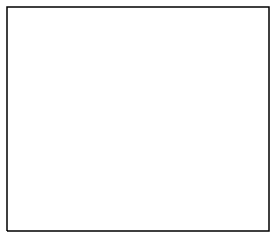

In [13]:

lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_vel_color = cmaps.cmocean_balance.colors[128:][:]
my_vel = LinearSegmentedColormap.from_list('vel',my_vel_color, N = 256)

#
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)
figsize = (11,5)

d_interval = 0.1
iwnl = 0
iwda = 0
iwda1 =1
plt.rcParams['font.family'] = 'Lucida Grande'
area = 'ks'
# for area in ['bh','ys','cre','ks','all']:
for area in ['all',]:
    if area == 'bh':
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 15
        
        bc = 0.98
    elif area == 'ys':
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vec_interval = 8
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        bc = 0.965
    elif area == 'ks':
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        
        lon_interval = 4
        lat_interval = 3
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.965
    elif area =='all':
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];

        lon_interval = 5
        lat_interval = 5
        vec_interval = 10
        vmin_sst = 0
        vmax_sst = 1.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.93
    for it in range(1,len(daa_UVars[area][iwda].ocean_time)):
    # for it in range(1,3):
        
        fig = plt.figure(figsize=figsize, constrained_layout = True)
        #===============================observation spatial pattern
        ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        # ax.tick_params('x',labelbottom=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
        ax.pcolormesh(nl_UVars[area][iwnl].lon,nl_UVars[area][iwnl].lat,
                       np.sqrt(daa_UVars[area][iwda].value_rotate[it,:,:]**2 + daa_VVars[area][iwda].value_rotate[it,:,:]**2),
                   cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.quiver(nl_UVars[area][iwnl].lon[::vec_interval,::vec_interval],nl_UVars[area][iwnl].lat[::vec_interval,::vec_interval],
                  0.5*(nl_UVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval]+nl_UVars[area][iwnl].value_rotate[it-1,::vec_interval,::vec_interval]),
                  0.5*(nl_VVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval]+nl_VVars[area][iwnl].value_rotate[it-1,::vec_interval,::vec_interval]), 
                  scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
                               transform = ccrs.PlateCarree())
        ax.set_title('Posterior exp_adj_ini',fontsize=16)
        ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(daa_UVars[area][iwda].ocean_time.data[it])[:10]+'-%sH'%(str(daa_UVars[area][iwda].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
        #===============================posterior spatial pattern
        ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)

        c2=ax.pcolormesh(daa_UVars[area][iwda].lon,daa_UVars[area][iwda].lat,
                       np.sqrt(daa_UVars[area][iwda1].value_rotate[it,:,:]**2 + daa_VVars[area][iwda1].value_rotate[it,:,:]**2),
                   cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.quiver(daa_UVars[area][iwnl].lon[::vec_interval,::vec_interval],daa_UVars[area][iwnl].lat[::vec_interval,::vec_interval],
                  daa_UVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval],
                  daa_VVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval], 
                  scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
                               transform = ccrs.PlateCarree())
        ax.set_title('Posterior exp_adj_ini_nud',fontsize=16)

                #==== colobar
        
        position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
        cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        cb.set_label('$m/s^{-1}$',fontsize = 12) 
        #===============================innovation spatial pattern
        ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        cb3 = ax.pcolormesh(daa_UVars[area][iwda].lon,daa_UVars[area][iwda].lat,
                       np.sqrt(daa_UVars[area][iwda1].value_rotate[it,:,:]**2 + daa_VVars[area][iwda1].value_rotate[it,:,:]**2)
                            -
                           np.sqrt(daa_UVars[area][iwda].value_rotate[it,:,:]**2 + daa_VVars[area][iwda].value_rotate[it,:,:]**2),
                   cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Difference',fontsize=16)
            #---- colrbar
        
        position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


        cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        cb2.set_label('$m/s^{-1}$',fontsize = 12) 
        # fig.colorbar(c3)
        # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

        # fig = plt.figure(figsize=figsize, constrained_layout = True)

        #===============================observation spatial pattern
#         
        plt.savefig('./fig_contrast/adj_ini.vs.adj_ini_nud/post/ssvel/%s/%s.jpeg'%(area,str(it)),dpi=300,bbox_inches='tight')
        plt.close()

In [59]:

lon_bdy = [120,133.5];
lat_bdy = [20,31];
vmin_sst = 22
vmax_sst = 26
my_sst_color = sio.loadmat('LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_vel_color = cmaps.cmocean_balance.colors[128:][:]
my_vel = LinearSegmentedColormap.from_list('vel',my_vel_color, N = 256)

#
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)
figsize = (11,5)

d_interval = 0.1
iwnl = 2
iwda = 3
iwda1 =1
plt.rcParams['font.family'] = 'Lucida Grande'
area = 'ks'
# for area in ['bh','ys','cre','ks','all']:
for area in ['all',]:
    if area == 'bh':
        lon_bdy = [116.5,123.5];
        lat_bdy = [36,42];
        lon_interval = 3
        lat_interval = 3
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 15
        
        bc = 0.98
    elif area == 'ys':
        lon_bdy = [122,128];
        lat_bdy = [34,38];
        lon_interval = 2
        lat_interval = 2
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        markersize = 20
        bc = 0.978
    elif area == 'cre':
        lon_bdy = [119.5,130.5];
        lat_bdy = [27,35];
        lon_interval = 3
        lat_interval = 3
        vec_interval = 8
        vmin_sst = 0
        vmax_sst = 1.5
        d_interval = 0.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        bc = 0.965
    elif area == 'ks':
        lon_bdy = [120,133.5];

        lat_bdy = [20,31];
        
        lon_interval = 4
        lat_interval = 3
        vec_interval = 5
        vmin_sst = 0
        vmax_sst = 1.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.965
    elif area =='all':
        lon_bdy = [116,136];
        lat_bdy = [21,38.5];

        lon_interval = 5
        lat_interval = 5
        vec_interval = 10
        vmin_sst = 0
        vmax_sst = 1.5
        vmin_diff = -0.5
        vmax_diff = 0.5
        d_interval = 0.5
        bc = 0.93
    # for it in range(1,len(daa_UVars[area][iwda].ocean_time)):
    for it in range(1,100):
        
        fig = plt.figure(figsize=figsize, constrained_layout = True)
        #===============================observation spatial pattern
        ax = fig.add_subplot(1,3,1,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1,)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1,)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        # ax.tick_params('x',labelbottom=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
        # ax.scatter(obs_location[area_index,0],obs_location[area_index,1],10,daa_Vars['ys'].val_obsgrd[11,area_index],marker='s',transform = ccrs.PlateCarree())
#         ax.pcolormesh(nl_UVars[area][iwnl].lon,nl_UVars[area][iwnl].lat,
#                        np.sqrt(daa_UVars[area][iwda].value_rotate[it,:,:]**2 + daa_VVars[area][iwda].value_rotate[it,:,:]**2),
#                    cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,
                   
#                    transform = ccrs.PlateCarree(),zorder = -1)
        ax.pcolormesh(nl_UVars[area][iwnl].lon,nl_UVars[area][iwnl].lat,
                       0.5*(
                               np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
                               +
                               np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
                           ),
                   cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.quiver(nl_UVars[area][iwnl].lon[::vec_interval,::vec_interval],nl_UVars[area][iwnl].lat[::vec_interval,::vec_interval],
                  0.5*(nl_UVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval]+nl_UVars[area][iwnl].value_rotate[it-1,::vec_interval,::vec_interval]),
                  0.5*(nl_VVars[area][iwnl].value_rotate[it,::vec_interval,::vec_interval]+nl_VVars[area][iwnl].value_rotate[it-1,::vec_interval,::vec_interval]), 
                  scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
                               transform = ccrs.PlateCarree())
        # ax.set_title('Forward ROMS 3.7 LOG drag',fontsize=16)
        # ax.set_title('Forward ROMS 3.7 Quadratic drag',fontsize=16)
        ax.set_title('Forward ROMS 3.7 Quadratic drag \n no correction',fontsize=12)
        ax.text(lon_bdy[-1]*bc,lat_bdy[-1]*0.99,str(nl_UVars[area][1].ocean_time.data[it])[:10]+'-%sH'%(str(daa_UVars[area][1].ocean_time.data[it])[11:13]),fontsize = 12,transform = ccrs.PlateCarree())
        #===============================posterior spatial pattern
        ax = fig.add_subplot(1,3,2,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)

#         c2=ax.pcolormesh(nl_UVars[area][iwda].lon,nl_UVars[area][iwda].lat,
#                        0.5*(
#                                np.sqrt(nl_UVars[area][iwda].value_rotate[it,:,:]**2+nl_VVars[area][iwda].value_rotate[it,:,:]**2)
#                                +
#                                np.sqrt(nl_UVars[area][iwda].value_rotate[it-1,:,:]**2+nl_VVars[area][iwda].value_rotate[it-1,:,:]**2)
#                            ),
#                    cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,
                   
#                    transform = ccrs.PlateCarree(),zorder = -1)
        c2=ax.pcolormesh(nl_UVars[area][iwda].lon,nl_UVars[area][iwda].lat,
                      
                               
                               np.sqrt(nl_UVars[area][iwda].value_rotate[it-1,:,:]**2+nl_VVars[area][iwda].value_rotate[it-1,:,:]**2)
                           ,
                   cmap = my_vel,vmin = vmin_sst,vmax=vmax_sst,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        # ax.quiver(nl_UVars[area][iwda].lon[::vec_interval,::vec_interval],nl_UVars[area][iwda].lat[::vec_interval,::vec_interval],
        #           0.5*(nl_UVars[area][iwda].value_rotate[it,::vec_interval,::vec_interval]+nl_UVars[area][iwda].value_rotate[it-1,::vec_interval,::vec_interval]),
        #           0.5*(nl_VVars[area][iwda].value_rotate[it,::vec_interval,::vec_interval]+nl_VVars[area][iwda].value_rotate[it-1,::vec_interval,::vec_interval]), 
        #           scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
        #                        transform = ccrs.PlateCarree())
        ax.quiver(nl_UVars[area][iwda].lon[::vec_interval,::vec_interval],nl_UVars[area][iwda].lat[::vec_interval,::vec_interval],
                  nl_UVars[area][iwda].value_rotate[it-1,::vec_interval,::vec_interval],
                  nl_VVars[area][iwda].value_rotate[it-1,::vec_interval,::vec_interval], 
                  scale = 20,width = 0.005, headaxislength = 2.5,headlength = 2.5, headwidth = 2.5,
                               transform = ccrs.PlateCarree())
        # ax.set_title('Forward ROMS 3.7 Quadratic drag',fontsize=16)
        # ax.set_title('Forward ROMS 3.7 Quadratic drag no correction',fontsize=16)
        ax.set_title('Forward ROMS 4.1 Quadratic drag \n no correction',fontsize=12)
        # ax.set_title('Forward ROMS 4.1 Quadratic drag',fontsize=16)

                #==== colobar
        
        position=fig.add_axes([ 0.1875,0.0, 0.325, 0.045,])
        cb = fig.colorbar(c2, cax = position, orientation='horizontal',ticks = np.arange(vmin_sst,vmax_sst+d_interval,d_interval))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)

        cb.set_label('$m/s^{-1}$',fontsize = 12) 
        #===============================innovation spatial pattern
        ax = fig.add_subplot(1,3,3,projection = ccrs.Mercator())
        for bnd in ax.spines.keys():
            ax.spines[bnd].set_linewidth('1.5')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
        ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = 1)
        ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
        ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+lon_interval,lon_interval),crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1]+lat_interval,lat_interval),crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.0f',
                                        degree_symbol='°',
                                        dateline_direction_label=True)
        lat_formatter = LatitudeFormatter(number_format='.0f',
                                            degree_symbol='°')
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params(direction = 'out', length = 3, width = 1.5, labelsize = 12)
        ax.tick_params('x',labelbottom=False)
        ax.tick_params('y',labelleft=False)
        # area_index = np.where(~np.isnan(daa_Vars[area].val_obsgrd[0,:]))
#         cb3 = ax.pcolormesh(nl_UVars[area][iwda].lon,nl_UVars[area][iwda].lat,
#                        0.5*(
#                                np.sqrt(nl_UVars[area][iwda].value_rotate[it,:,:]**2+nl_VVars[area][iwda].value_rotate[it,:,:]**2)
#                                +
#                                np.sqrt(nl_UVars[area][iwda].value_rotate[it-1,:,:]**2+nl_VVars[area][iwda].value_rotate[it-1,:,:]**2)
#                            )
#                             -
#                            0.5*(
#                                np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
#                                +
#                                np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
#                            ),
#                    cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,
                   
#                    transform = ccrs.PlateCarree(),zorder = -1)
        cb3 = ax.pcolormesh(nl_UVars[area][iwda].lon,nl_UVars[area][iwda].lat,
                       
                               np.sqrt(nl_UVars[area][iwda].value_rotate[it-1,:,:]**2+nl_VVars[area][iwda].value_rotate[it-1,:,:]**2)
                           
                            -
                           0.5*(
                               np.sqrt(nl_UVars[area][iwnl].value_rotate[it,:,:]**2+nl_VVars[area][iwnl].value_rotate[it,:,:]**2)
                               +
                               np.sqrt(nl_UVars[area][iwnl].value_rotate[it-1,:,:]**2+nl_VVars[area][iwnl].value_rotate[it-1,:,:]**2)
                           ),
                   cmap = my_div,vmin =vmin_diff,vmax=vmax_diff,
                   
                   transform = ccrs.PlateCarree(),zorder = -1)
        ax.set_title('Difference',fontsize=16)
            #---- colrbar
        
        position=fig.add_axes([ 0.7575,0.0, 0.165, 0.045,])


        cb2 = fig.colorbar(cb3, cax = position, orientation='horizontal',ticks = np.arange(vmin_diff,vmax_diff+vmax_diff,vmax_diff))
        for bnd in position.spines.keys():
                position.spines[bnd].set_linewidth('1.5')
        position.tick_params(direction = 'out',  length = 3, width = 1.5, labelsize = 12)
        cb2.set_label('$m/s^{-1}$',fontsize = 12) 
        # fig.colorbar(c3)
        # plt.savefig('roms_i4dvar_valid2d_obsgrd_adj_ini.pdf',bbox_inches='tight')

        # fig = plt.figure(figsize=figsize, constrained_layout = True)

        #===============================observation spatial pattern
#         
        plt.savefig('./fig_contrast/roms4.1_qrad_nocorr-roms_3.7_qrad_nocorr/ssvel_%s.jpeg'%(str(it)),dpi=300,bbox_inches='tight')
        plt.close()

/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anaconda3/envs/m1base/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/onecountrylee/opt/anacond

In [ ]:

for t in range(1):
    for i in range(daa_UVars['ys'][0].lon.shape[1]):
        for j in range(1,daa_UVars['ys'][0].lon.shape[0]):
            u_rho[j,i] = 0.5*(u[t,j-1,i] + u[t,j,i])

In [ ]:
1483747200/86400

In [50]:
nl_UVars[area][iwnl].ocean_time[it]

<xarray.DataArray 'ocean_time' ()>
array('2017-01-03T07:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    s_rho       float64 -0.025
    ocean_time  datetime64[ns] 2017-01-03T07:30:00
Attributes:
    long_name:  averaged time since initialization
    field:      time, scalar, series